All codes made with the help of Chat gpt and Github CoPilot by feeding the question subpart as the prompt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, query, key, value):
        # Calculate the dot product attention scores
        d_k = query.size(-1)  # key dimension
        scores = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(d_k)
        attention_weights = torch.nn.functional.softmax(scores, dim=-1)
        out = torch.matmul(attention_weights, value)
        return out, attention_weights
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_size = embed_size
        self.head_dim = embed_size // num_heads

        assert self.head_dim * num_heads == embed_size, "Embedding size must be divisible by number of heads."

        self.query_linear = nn.Linear(embed_size, embed_size)
        self.key_linear = nn.Linear(embed_size, embed_size)
        self.value_linear = nn.Linear(embed_size, embed_size)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, query, key, value):
        N = query.size(0)

        # Split the embedding into self.num_heads different heads
        query = query.view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)
        key = key.view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)
        value = value.view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention for each head
        attention, attention_weights = ScaledDotProductAttention()(query, key, value)

        # Concatenate all heads and pass through final linear layer
        attention = attention.transpose(1, 2).contiguous().view(N, -1, self.num_heads * self.head_dim)
        out = self.fc_out(attention)
        return out, attention_weights
    
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_size, num_heads, feedforward_dim, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.multihead_attention = MultiHeadAttention(embed_size, num_heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.ffn = nn.Sequential(
            nn.Linear(embed_size, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, embed_size)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Multi-head attention
        attention_out, _ = self.multihead_attention(x, x, x)
        x = self.norm1(x + self.dropout(attention_out))  # Skip connection

        # Feed-forward network
        ff_out = self.ffn(x)
        x = self.norm2(x + self.dropout(ff_out))  # Skip connection
        return x
    
class VisionTransformer(nn.Module):
    def __init__(self, num_classes, embed_size=256, num_heads=8, num_layers=6, patch_size=4, feedforward_dim=1024):
        super(VisionTransformer, self).__init__()
        
        self.patch_size = patch_size
        self.embed_size = embed_size
        
        self.conv1 = nn.Conv2d(3, embed_size, kernel_size=patch_size, stride=patch_size)  # Patchify the image
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_size))  # [CLS] token
        
        self.positional_embedding = nn.Parameter(torch.randn(1, (32 // patch_size)**2 + 1, embed_size))  # Positional encoding
        
        # Transformer encoder layers
        self.encoder_layers = nn.ModuleList(
            [TransformerEncoderBlock(embed_size, num_heads, feedforward_dim) for _ in range(num_layers)]
        )
        
        self.fc = nn.Linear(embed_size, num_classes)
        
    def forward(self, x):
        # Convert image to patches
        x = self.conv1(x)  # Patchify image
        x = x.flatten(2).transpose(1, 2)  # Flatten patches and transpose for transformer
        
        # Add the [CLS] token at the beginning
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)  # [CLS] token + patches
        
        # Add positional embeddings
        x = x + self.positional_embedding
        
        # Pass through transformer layers
        for layer in self.encoder_layers:
            x = layer(x)
        
        # The [CLS] token represents the global information
        cls_output = x[:, 0]
        
        # Classification head
        out = self.fc(cls_output)
        return out


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.89batch/s, accuracy=39.5]


Epoch [1/20], Loss: 1.8552, Test Accuracy: 39.48%


Testing: 100%|██████████| 157/157 [00:02<00:00, 70.47batch/s, accuracy=46.7]


Epoch [2/20], Loss: 1.5688, Test Accuracy: 46.69%


Testing: 100%|██████████| 157/157 [00:01<00:00, 78.96batch/s, accuracy=50.5]


Epoch [3/20], Loss: 1.4489, Test Accuracy: 50.46%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.92batch/s, accuracy=53.4]


Epoch [4/20], Loss: 1.3683, Test Accuracy: 53.41%


Testing: 100%|██████████| 157/157 [00:02<00:00, 66.00batch/s, accuracy=55.7]


Epoch [5/20], Loss: 1.3002, Test Accuracy: 55.66%


Testing: 100%|██████████| 157/157 [00:02<00:00, 74.16batch/s, accuracy=54.5]


Epoch [6/20], Loss: 1.2402, Test Accuracy: 54.47%


Testing: 100%|██████████| 157/157 [00:02<00:00, 63.63batch/s, accuracy=56.8]


Epoch [7/20], Loss: 1.1863, Test Accuracy: 56.83%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.10batch/s, accuracy=57.6]


Epoch [8/20], Loss: 1.1390, Test Accuracy: 57.64%


Testing: 100%|██████████| 157/157 [00:02<00:00, 74.70batch/s, accuracy=58.9]


Epoch [9/20], Loss: 1.0900, Test Accuracy: 58.91%


Testing: 100%|██████████| 157/157 [00:02<00:00, 74.45batch/s, accuracy=61.8]


Epoch [10/20], Loss: 1.0509, Test Accuracy: 61.76%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.09batch/s, accuracy=62.5]


Epoch [11/20], Loss: 1.0120, Test Accuracy: 62.51%


Testing: 100%|██████████| 157/157 [00:02<00:00, 74.30batch/s, accuracy=62.5]


Epoch [12/20], Loss: 0.9777, Test Accuracy: 62.45%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.20batch/s, accuracy=64.5]


Epoch [13/20], Loss: 0.9485, Test Accuracy: 64.55%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.83batch/s, accuracy=64.2]


Epoch [14/20], Loss: 0.9107, Test Accuracy: 64.16%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.75batch/s, accuracy=64.2]


Epoch [15/20], Loss: 0.8774, Test Accuracy: 64.15%


Testing: 100%|██████████| 157/157 [00:02<00:00, 74.18batch/s, accuracy=64.7]


Epoch [16/20], Loss: 0.8490, Test Accuracy: 64.68%


Testing: 100%|██████████| 157/157 [00:02<00:00, 74.59batch/s, accuracy=65.5]


Epoch [17/20], Loss: 0.8176, Test Accuracy: 65.52%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.33batch/s, accuracy=65.4]


Epoch [18/20], Loss: 0.7916, Test Accuracy: 65.40%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.66batch/s, accuracy=66.5]


Epoch [19/20], Loss: 0.7640, Test Accuracy: 66.48%


Testing: 100%|██████████| 157/157 [00:02<00:00, 74.32batch/s, accuracy=66.8]


Epoch [20/20], Loss: 0.7343, Test Accuracy: 66.80%


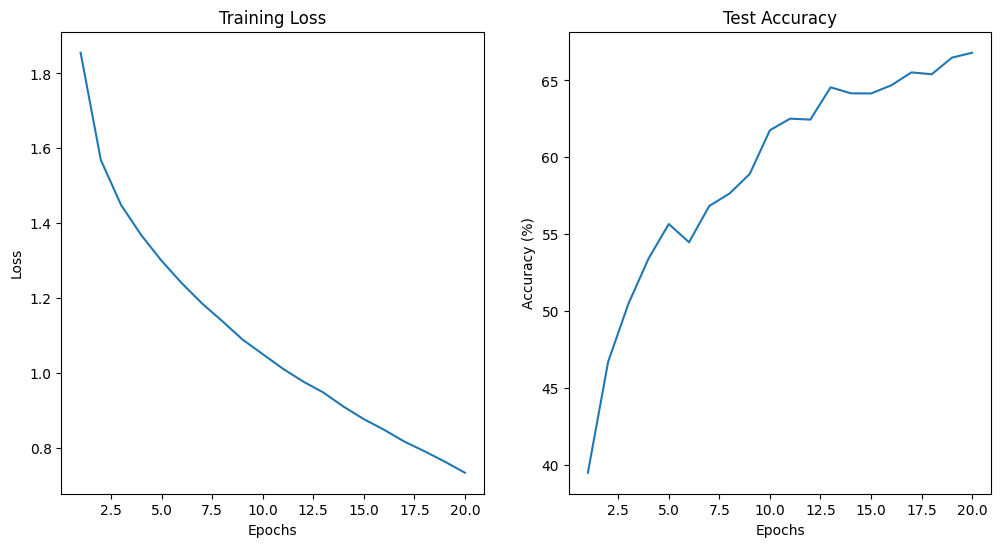

In [15]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer(num_classes=10,patch_size=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop with tqdm
epochs = 20
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Wrap the train_loader with tqdm to show progress
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update the progress bar description with loss value
            pbar.set_postfix(loss=running_loss / len(pbar), accuracy=100 * correct / total)

    # Record training loss
    train_losses.append(running_loss / len(train_loader))
    
    # Test accuracy
    model.eval()
    correct = 0
    total = 0
    
    # Wrap the test_loader with tqdm to show progress
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar:
        with torch.no_grad():
            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Update progress bar description with accuracy
                pbar.set_postfix(accuracy=100 * correct / total)
    
    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_losses[-1]:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
# Plot loss and accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), test_accuracies)
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")

plt.show()

Patch size variations

already did patch size 4

In [18]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device, epochs=20):
    from tqdm import tqdm
    import matplotlib.pyplot as plt

    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        batch_count = 0

        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                batch_count += 1

                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

                pbar.set_postfix(
                    loss=running_loss / batch_count,
                    accuracy=100 * correct / total
                )

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluation
        model.eval()
        correct = 0
        total = 0

        with tqdm(test_loader, desc="Testing", unit="batch") as pbar:
            with torch.no_grad():
                for inputs, labels in pbar:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    pbar.set_postfix(accuracy=100 * correct / total)

        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_train_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")

    return train_losses, test_accuracies



def plot_loss_and_accuracy(train_losses, test_accuracies, epochs):
    """
    Plots training loss and test accuracy curves over `epochs`.
    """
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, marker='o')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, test_accuracies, marker='o')
    plt.title("Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")

    plt.tight_layout()
    plt.show()

cuda

Training with patch size: 8


Testing: 100%|██████████| 157/157 [00:01<00:00, 108.78batch/s, accuracy=40.8]


Epoch [1/10] | Loss: 1.8462 | Test Accuracy: 40.81%


Testing: 100%|██████████| 157/157 [00:01<00:00, 101.14batch/s, accuracy=48.6]


Epoch [2/10] | Loss: 1.5505 | Test Accuracy: 48.63%


Testing: 100%|██████████| 157/157 [00:01<00:00, 95.68batch/s, accuracy=49.5]


Epoch [3/10] | Loss: 1.4417 | Test Accuracy: 49.45%


Testing: 100%|██████████| 157/157 [00:01<00:00, 101.97batch/s, accuracy=52.4]


Epoch [4/10] | Loss: 1.3695 | Test Accuracy: 52.41%


Testing: 100%|██████████| 157/157 [00:01<00:00, 99.67batch/s, accuracy=53.4] 


Epoch [5/10] | Loss: 1.3009 | Test Accuracy: 53.35%


Testing: 100%|██████████| 157/157 [00:01<00:00, 101.95batch/s, accuracy=54]  


Epoch [6/10] | Loss: 1.2537 | Test Accuracy: 54.03%


Testing: 100%|██████████| 157/157 [00:01<00:00, 101.24batch/s, accuracy=56.5]


Epoch [7/10] | Loss: 1.2044 | Test Accuracy: 56.47%


Testing: 100%|██████████| 157/157 [00:01<00:00, 99.62batch/s, accuracy=55.6]


Epoch [8/10] | Loss: 1.1655 | Test Accuracy: 55.60%


Testing: 100%|██████████| 157/157 [00:01<00:00, 101.03batch/s, accuracy=57.8]


Epoch [9/10] | Loss: 1.1271 | Test Accuracy: 57.75%


Testing: 100%|██████████| 157/157 [00:01<00:00, 100.92batch/s, accuracy=59.3]


Epoch [10/10] | Loss: 1.0884 | Test Accuracy: 59.32%


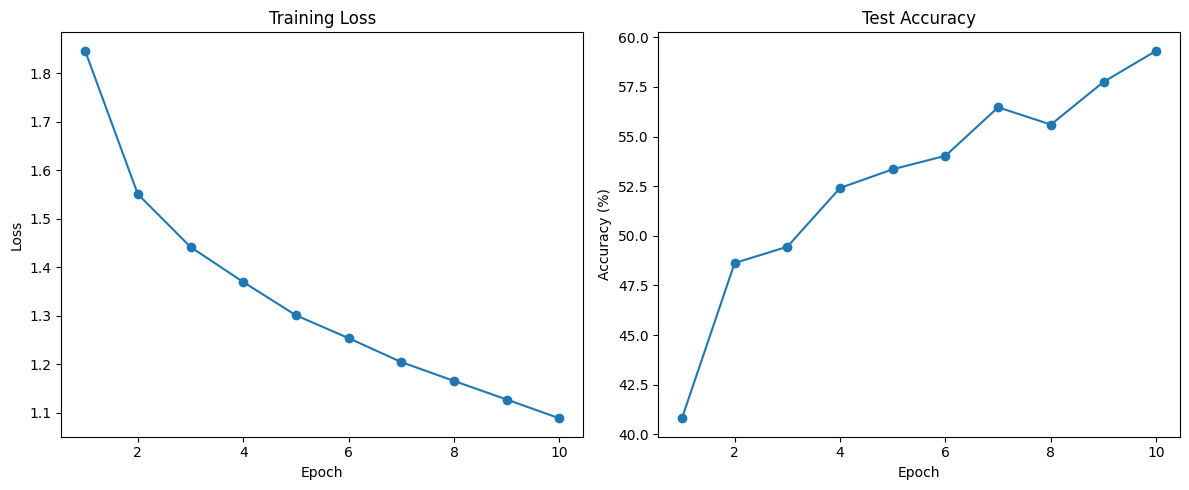

👉 Final Test Accuracy for patch size 8: 59.32%

Training with patch size: 2


Testing: 100%|██████████| 157/157 [00:08<00:00, 18.98batch/s, accuracy=39.9]


Epoch [1/10] | Loss: 1.8965 | Test Accuracy: 39.94%


Testing: 100%|██████████| 157/157 [00:08<00:00, 18.86batch/s, accuracy=45.5]


Epoch [2/10] | Loss: 1.6246 | Test Accuracy: 45.55%


Testing: 100%|██████████| 157/157 [00:08<00:00, 18.79batch/s, accuracy=48.5]


Epoch [3/10] | Loss: 1.5054 | Test Accuracy: 48.55%


Testing: 100%|██████████| 157/157 [00:08<00:00, 18.56batch/s, accuracy=50.8]


Epoch [4/10] | Loss: 1.4113 | Test Accuracy: 50.78%


Testing: 100%|██████████| 157/157 [00:08<00:00, 18.86batch/s, accuracy=54.1]


Epoch [5/10] | Loss: 1.3398 | Test Accuracy: 54.09%


Testing: 100%|██████████| 157/157 [00:24<00:00,  6.40batch/s, accuracy=53.8]


Epoch [6/10] | Loss: 1.2773 | Test Accuracy: 53.78%


Testing: 100%|██████████| 157/157 [00:08<00:00, 18.78batch/s, accuracy=55.7]


Epoch [7/10] | Loss: 1.2267 | Test Accuracy: 55.68%


Testing: 100%|██████████| 157/157 [00:08<00:00, 18.73batch/s, accuracy=57.8]


Epoch [8/10] | Loss: 1.1748 | Test Accuracy: 57.76%


Testing: 100%|██████████| 157/157 [00:08<00:00, 18.38batch/s, accuracy=59.4]


Epoch [9/10] | Loss: 1.1312 | Test Accuracy: 59.39%


Testing: 100%|██████████| 157/157 [00:08<00:00, 17.95batch/s, accuracy=58.8]


Epoch [10/10] | Loss: 1.0826 | Test Accuracy: 58.83%


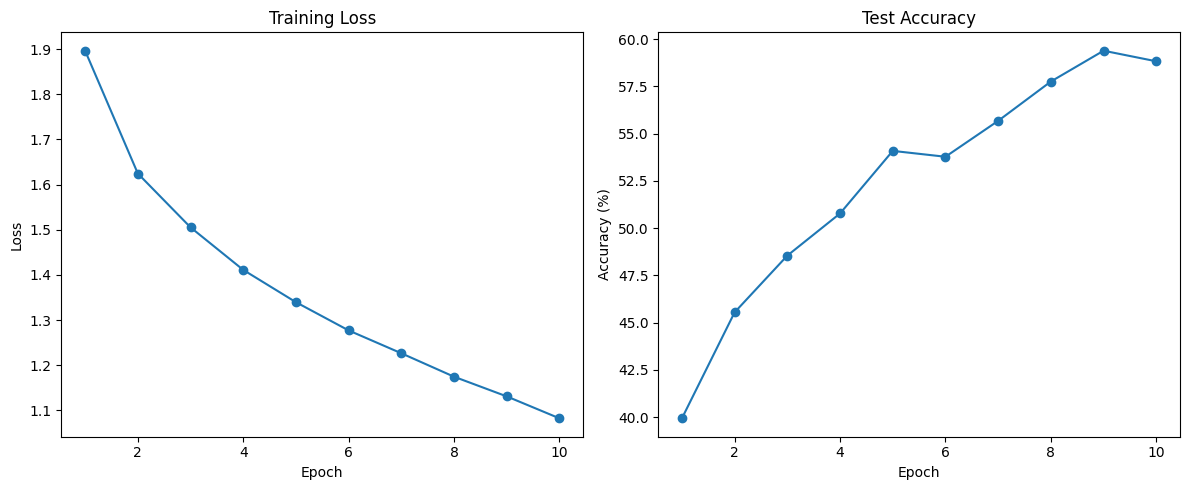

👉 Final Test Accuracy for patch size 2: 58.83%


In [24]:
# Define patch sizes for experimentation
patch_sizes = [8,2]
print(device)

# Loop through each patch size and train/evaluate the model
for patch_size in patch_sizes:
    print(f"\nTraining with patch size: {patch_size}")
    
    # Instantiate the model with the current patch size
    model = VisionTransformer(
        num_classes=10,
        embed_size=256,       # token embedding dimension
        num_heads=8,          # attention heads
        num_layers=6,         # transformer blocks
        patch_size=patch_size,
        feedforward_dim=1024  # hidden dim in each MLP block
    ).to(device)
    
    # Optimizer & loss
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    # Train and evaluate
    train_losses, test_accuracies = train_and_evaluate(
        model, train_loader, test_loader,
        criterion, optimizer, device,
        epochs=10
    )
    
    # Plot results
    plot_loss_and_accuracy(train_losses, test_accuracies, epochs=10)
    print(f"👉 Final Test Accuracy for patch size {patch_size}: {test_accuracies[-1]:.2f}%")

#hyperparameter tuning

In [27]:
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device, epochs=20, scheduler=None, save_path="best_vit_model.pth"):
    train_losses = []
    test_accuracies = []
    best_accuracy = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        batch_count = 0

        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                batch_count += 1

                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

                pbar.set_postfix(
                    loss=running_loss / batch_count,
                    accuracy=100 * correct / total
                )

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Step the scheduler after each epoch
        if scheduler is not None:
            scheduler.step()

        # Evaluation
        model.eval()
        correct = 0
        total = 0

        with tqdm(test_loader, desc="Testing", unit="batch") as pbar:
            with torch.no_grad():
                for inputs, labels in pbar:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    pbar.set_postfix(accuracy=100 * correct / total)

        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)

        # Save the best model
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), save_path)
            print(f"✅ New best model saved at epoch {epoch+1} with {best_accuracy:.2f}% accuracy")

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_train_loss:.4f} | Test Accuracy: {test_accuracy:.2f}% | LR: {current_lr:.6f}")

    return train_losses, test_accuracies


Testing: 100%|██████████| 157/157 [00:02<00:00, 72.30batch/s, accuracy=42.6]


✅ New best model saved at epoch 1 with 42.65% accuracy
Epoch [1/50] | Loss: 1.8646 | Test Accuracy: 42.65%


Testing: 100%|██████████| 157/157 [00:02<00:00, 72.24batch/s, accuracy=46.9]


✅ New best model saved at epoch 2 with 46.89% accuracy
Epoch [2/50] | Loss: 1.5676 | Test Accuracy: 46.89%


Testing: 100%|██████████| 157/157 [00:02<00:00, 72.66batch/s, accuracy=51.7]


✅ New best model saved at epoch 3 with 51.70% accuracy
Epoch [3/50] | Loss: 1.4367 | Test Accuracy: 51.70%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.07batch/s, accuracy=53.3]


✅ New best model saved at epoch 4 with 53.30% accuracy
Epoch [4/50] | Loss: 1.3446 | Test Accuracy: 53.30%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.16batch/s, accuracy=53.9]


✅ New best model saved at epoch 5 with 53.85% accuracy
Epoch [5/50] | Loss: 1.2728 | Test Accuracy: 53.85%


Testing: 100%|██████████| 157/157 [00:02<00:00, 72.98batch/s, accuracy=56.4]


✅ New best model saved at epoch 6 with 56.43% accuracy
Epoch [6/50] | Loss: 1.2179 | Test Accuracy: 56.43%


Testing: 100%|██████████| 157/157 [00:02<00:00, 71.97batch/s, accuracy=57.8]


✅ New best model saved at epoch 7 with 57.76% accuracy
Epoch [7/50] | Loss: 1.1620 | Test Accuracy: 57.76%


Testing: 100%|██████████| 157/157 [00:02<00:00, 72.82batch/s, accuracy=58.2]


✅ New best model saved at epoch 8 with 58.19% accuracy
Epoch [8/50] | Loss: 1.1209 | Test Accuracy: 58.19%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.88batch/s, accuracy=59.6]


✅ New best model saved at epoch 9 with 59.57% accuracy
Epoch [9/50] | Loss: 1.0725 | Test Accuracy: 59.57%


Testing: 100%|██████████| 157/157 [00:02<00:00, 74.27batch/s, accuracy=61.3]


✅ New best model saved at epoch 10 with 61.30% accuracy
Epoch [10/50] | Loss: 1.0314 | Test Accuracy: 61.30%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.04batch/s, accuracy=62.6]


✅ New best model saved at epoch 11 with 62.60% accuracy
Epoch [11/50] | Loss: 0.9939 | Test Accuracy: 62.60%


Testing: 100%|██████████| 157/157 [00:02<00:00, 71.63batch/s, accuracy=62.2]


Epoch [12/50] | Loss: 0.9576 | Test Accuracy: 62.18%


Testing: 100%|██████████| 157/157 [00:02<00:00, 72.69batch/s, accuracy=63]  


✅ New best model saved at epoch 13 with 62.95% accuracy
Epoch [13/50] | Loss: 0.9245 | Test Accuracy: 62.95%


Testing: 100%|██████████| 157/157 [00:02<00:00, 71.68batch/s, accuracy=65]  


✅ New best model saved at epoch 14 with 64.99% accuracy
Epoch [14/50] | Loss: 0.8919 | Test Accuracy: 64.99%


Testing: 100%|██████████| 157/157 [00:02<00:00, 72.13batch/s, accuracy=64.3]


Epoch [15/50] | Loss: 0.8599 | Test Accuracy: 64.32%


Testing: 100%|██████████| 157/157 [00:02<00:00, 72.71batch/s, accuracy=66.1]


✅ New best model saved at epoch 16 with 66.14% accuracy
Epoch [16/50] | Loss: 0.8275 | Test Accuracy: 66.14%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.08batch/s, accuracy=66.8]


✅ New best model saved at epoch 17 with 66.76% accuracy
Epoch [17/50] | Loss: 0.7946 | Test Accuracy: 66.76%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.34batch/s, accuracy=67.2]


✅ New best model saved at epoch 18 with 67.21% accuracy
Epoch [18/50] | Loss: 0.7711 | Test Accuracy: 67.21%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.13batch/s, accuracy=65]  


Epoch [19/50] | Loss: 0.7426 | Test Accuracy: 64.99%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.71batch/s, accuracy=67.1]


Epoch [20/50] | Loss: 0.7119 | Test Accuracy: 67.13%


Testing: 100%|██████████| 157/157 [00:02<00:00, 72.69batch/s, accuracy=67.7]


✅ New best model saved at epoch 21 with 67.72% accuracy
Epoch [21/50] | Loss: 0.6854 | Test Accuracy: 67.72%


Testing: 100%|██████████| 157/157 [00:02<00:00, 72.42batch/s, accuracy=67.7]


✅ New best model saved at epoch 22 with 67.74% accuracy
Epoch [22/50] | Loss: 0.6604 | Test Accuracy: 67.74%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.56batch/s, accuracy=68.4]


✅ New best model saved at epoch 23 with 68.43% accuracy
Epoch [23/50] | Loss: 0.6346 | Test Accuracy: 68.43%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.95batch/s, accuracy=69]  


✅ New best model saved at epoch 24 with 69.02% accuracy
Epoch [24/50] | Loss: 0.6098 | Test Accuracy: 69.02%


Testing: 100%|██████████| 157/157 [00:02<00:00, 74.34batch/s, accuracy=69.2]


✅ New best model saved at epoch 25 with 69.18% accuracy
Epoch [25/50] | Loss: 0.5893 | Test Accuracy: 69.18%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.03batch/s, accuracy=68.3]


Epoch [26/50] | Loss: 0.5639 | Test Accuracy: 68.33%


Testing: 100%|██████████| 157/157 [00:02<00:00, 71.85batch/s, accuracy=69.7]


✅ New best model saved at epoch 27 with 69.74% accuracy
Epoch [27/50] | Loss: 0.5365 | Test Accuracy: 69.74%


Testing: 100%|██████████| 157/157 [00:02<00:00, 72.96batch/s, accuracy=68.6]


Epoch [28/50] | Loss: 0.5124 | Test Accuracy: 68.63%


Testing: 100%|██████████| 157/157 [00:02<00:00, 74.41batch/s, accuracy=69.8]


✅ New best model saved at epoch 29 with 69.82% accuracy
Epoch [29/50] | Loss: 0.4923 | Test Accuracy: 69.82%


Testing: 100%|██████████| 157/157 [00:02<00:00, 75.72batch/s, accuracy=69.8]


Epoch [30/50] | Loss: 0.4707 | Test Accuracy: 69.77%


Testing: 100%|██████████| 157/157 [00:02<00:00, 78.31batch/s, accuracy=69.9]


✅ New best model saved at epoch 31 with 69.89% accuracy
Epoch [31/50] | Loss: 0.4469 | Test Accuracy: 69.89%


Testing: 100%|██████████| 157/157 [00:02<00:00, 78.33batch/s, accuracy=68.8]


Epoch [32/50] | Loss: 0.4303 | Test Accuracy: 68.83%


Testing: 100%|██████████| 157/157 [00:02<00:00, 75.62batch/s, accuracy=69.7]


Epoch [33/50] | Loss: 0.4070 | Test Accuracy: 69.72%


Testing: 100%|██████████| 157/157 [00:02<00:00, 75.59batch/s, accuracy=68.6]


Epoch [34/50] | Loss: 0.3918 | Test Accuracy: 68.61%


Testing: 100%|██████████| 157/157 [00:02<00:00, 74.62batch/s, accuracy=69]  


Epoch [35/50] | Loss: 0.3718 | Test Accuracy: 69.04%


Testing: 100%|██████████| 157/157 [00:02<00:00, 72.71batch/s, accuracy=69.6]


Epoch [36/50] | Loss: 0.3498 | Test Accuracy: 69.64%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.76batch/s, accuracy=69.8]


Epoch [37/50] | Loss: 0.3422 | Test Accuracy: 69.75%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.28batch/s, accuracy=70.2]


✅ New best model saved at epoch 38 with 70.20% accuracy
Epoch [38/50] | Loss: 0.3187 | Test Accuracy: 70.20%


Testing: 100%|██████████| 157/157 [00:02<00:00, 72.45batch/s, accuracy=70.1]


Epoch [39/50] | Loss: 0.3007 | Test Accuracy: 70.10%


Testing: 100%|██████████| 157/157 [00:02<00:00, 71.83batch/s, accuracy=69.9]


Epoch [40/50] | Loss: 0.2838 | Test Accuracy: 69.87%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.48batch/s, accuracy=68.9]


Epoch [41/50] | Loss: 0.2754 | Test Accuracy: 68.91%


Testing: 100%|██████████| 157/157 [00:02<00:00, 71.96batch/s, accuracy=70.1]


Epoch [42/50] | Loss: 0.2620 | Test Accuracy: 70.14%


Testing: 100%|██████████| 157/157 [00:02<00:00, 72.79batch/s, accuracy=70.3]


✅ New best model saved at epoch 43 with 70.27% accuracy
Epoch [43/50] | Loss: 0.2520 | Test Accuracy: 70.27%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.35batch/s, accuracy=69.7]


Epoch [44/50] | Loss: 0.2408 | Test Accuracy: 69.71%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.85batch/s, accuracy=69.7]


Epoch [45/50] | Loss: 0.2292 | Test Accuracy: 69.72%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.15batch/s, accuracy=70]  


Epoch [46/50] | Loss: 0.2215 | Test Accuracy: 70.05%


Testing: 100%|██████████| 157/157 [00:02<00:00, 72.78batch/s, accuracy=69.8]


Epoch [47/50] | Loss: 0.2109 | Test Accuracy: 69.78%


Testing: 100%|██████████| 157/157 [00:02<00:00, 72.69batch/s, accuracy=69.2]


Epoch [48/50] | Loss: 0.1995 | Test Accuracy: 69.18%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.87batch/s, accuracy=69.9]


Epoch [49/50] | Loss: 0.1961 | Test Accuracy: 69.91%


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.37batch/s, accuracy=70]  


Epoch [50/50] | Loss: 0.1837 | Test Accuracy: 69.95%


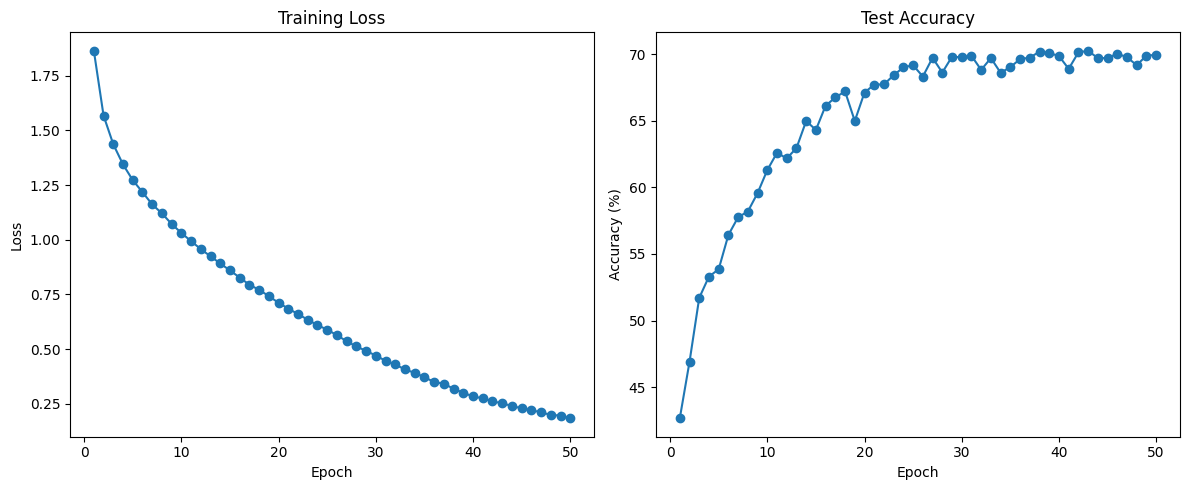

👉 Final Test Accuracy for patch size 2: 69.95%


In [26]:
model = VisionTransformer(
    num_classes=10,
    embed_size=256,       # token embedding dimension
    num_heads=8,          # attention heads
    num_layers=6,         # transformer blocks
    patch_size=4,
    feedforward_dim=1024  # hidden dim in each MLP block
).to(device)

# Optimizer & loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    # Train and evaluate
train_losses, test_accuracies = train_and_evaluate(
    model, train_loader, test_loader,
    criterion, optimizer, device,
    epochs=50
)
    
# Plot results
plot_loss_and_accuracy(train_losses, test_accuracies, epochs=50)
print(f"👉 Final Test Accuracy for patch size {patch_size}: {test_accuracies[-1]:.2f}%")

best accuracy i could get was 70.27%

Testing: 100%|██████████| 157/157 [00:02<00:00, 64.84batch/s, accuracy=42.5]


✅ New best model saved at epoch 1 with 42.49% accuracy
Epoch [1/50] | Loss: 1.8467 | Test Accuracy: 42.49% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.16batch/s, accuracy=47.8]


✅ New best model saved at epoch 2 with 47.79% accuracy
Epoch [2/50] | Loss: 1.5756 | Test Accuracy: 47.79% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.45batch/s, accuracy=49.9]


✅ New best model saved at epoch 3 with 49.86% accuracy
Epoch [3/50] | Loss: 1.4427 | Test Accuracy: 49.86% | LR: 0.000099


Testing: 100%|██████████| 157/157 [00:02<00:00, 70.22batch/s, accuracy=52.4]


✅ New best model saved at epoch 4 with 52.40% accuracy
Epoch [4/50] | Loss: 1.3545 | Test Accuracy: 52.40% | LR: 0.000098


Testing: 100%|██████████| 157/157 [00:02<00:00, 70.34batch/s, accuracy=55.1]


✅ New best model saved at epoch 5 with 55.11% accuracy
Epoch [5/50] | Loss: 1.2942 | Test Accuracy: 55.11% | LR: 0.000098


Testing: 100%|██████████| 157/157 [00:02<00:00, 63.54batch/s, accuracy=55.7]


✅ New best model saved at epoch 6 with 55.74% accuracy
Epoch [6/50] | Loss: 1.2405 | Test Accuracy: 55.74% | LR: 0.000096


Testing: 100%|██████████| 157/157 [00:02<00:00, 60.68batch/s, accuracy=57]  


✅ New best model saved at epoch 7 with 56.98% accuracy
Epoch [7/50] | Loss: 1.1933 | Test Accuracy: 56.98% | LR: 0.000095


Testing: 100%|██████████| 157/157 [00:02<00:00, 58.21batch/s, accuracy=59]  


✅ New best model saved at epoch 8 with 58.95% accuracy
Epoch [8/50] | Loss: 1.1404 | Test Accuracy: 58.95% | LR: 0.000094


Testing: 100%|██████████| 157/157 [00:02<00:00, 59.32batch/s, accuracy=58.4]


Epoch [9/50] | Loss: 1.1006 | Test Accuracy: 58.39% | LR: 0.000092


Testing: 100%|██████████| 157/157 [00:02<00:00, 59.91batch/s, accuracy=60.3]


✅ New best model saved at epoch 10 with 60.30% accuracy
Epoch [10/50] | Loss: 1.0614 | Test Accuracy: 60.30% | LR: 0.000090


Testing: 100%|██████████| 157/157 [00:02<00:00, 59.05batch/s, accuracy=60.4]


✅ New best model saved at epoch 11 with 60.36% accuracy
Epoch [11/50] | Loss: 1.0233 | Test Accuracy: 60.36% | LR: 0.000089


Testing: 100%|██████████| 157/157 [00:03<00:00, 47.47batch/s, accuracy=63.1]


✅ New best model saved at epoch 12 with 63.15% accuracy
Epoch [12/50] | Loss: 0.9792 | Test Accuracy: 63.15% | LR: 0.000086


Testing: 100%|██████████| 157/157 [00:02<00:00, 58.31batch/s, accuracy=64.1]


✅ New best model saved at epoch 13 with 64.10% accuracy
Epoch [13/50] | Loss: 0.9435 | Test Accuracy: 64.10% | LR: 0.000084


Testing: 100%|██████████| 157/157 [00:02<00:00, 57.42batch/s, accuracy=64.5]


✅ New best model saved at epoch 14 with 64.53% accuracy
Epoch [14/50] | Loss: 0.9095 | Test Accuracy: 64.53% | LR: 0.000082


Testing: 100%|██████████| 157/157 [00:02<00:00, 65.42batch/s, accuracy=65]  


✅ New best model saved at epoch 15 with 64.97% accuracy
Epoch [15/50] | Loss: 0.8766 | Test Accuracy: 64.97% | LR: 0.000079


Testing: 100%|██████████| 157/157 [00:02<00:00, 66.71batch/s, accuracy=65.8]


✅ New best model saved at epoch 16 with 65.82% accuracy
Epoch [16/50] | Loss: 0.8388 | Test Accuracy: 65.82% | LR: 0.000077


Testing: 100%|██████████| 157/157 [00:02<00:00, 57.81batch/s, accuracy=66.8]


✅ New best model saved at epoch 17 with 66.75% accuracy
Epoch [17/50] | Loss: 0.8068 | Test Accuracy: 66.75% | LR: 0.000074


Testing: 100%|██████████| 157/157 [00:02<00:00, 57.41batch/s, accuracy=67]  


✅ New best model saved at epoch 18 with 67.03% accuracy
Epoch [18/50] | Loss: 0.7788 | Test Accuracy: 67.03% | LR: 0.000071


Testing: 100%|██████████| 157/157 [00:02<00:00, 58.07batch/s, accuracy=68]  


✅ New best model saved at epoch 19 with 67.98% accuracy
Epoch [19/50] | Loss: 0.7438 | Test Accuracy: 67.98% | LR: 0.000068


Testing: 100%|██████████| 157/157 [00:02<00:00, 57.21batch/s, accuracy=69]  


✅ New best model saved at epoch 20 with 68.99% accuracy
Epoch [20/50] | Loss: 0.7166 | Test Accuracy: 68.99% | LR: 0.000065


Testing: 100%|██████████| 157/157 [00:02<00:00, 57.70batch/s, accuracy=69.1]


✅ New best model saved at epoch 21 with 69.11% accuracy
Epoch [21/50] | Loss: 0.6914 | Test Accuracy: 69.11% | LR: 0.000062


Testing: 100%|██████████| 157/157 [00:03<00:00, 48.06batch/s, accuracy=69.5]


✅ New best model saved at epoch 22 with 69.47% accuracy
Epoch [22/50] | Loss: 0.6607 | Test Accuracy: 69.47% | LR: 0.000059


Testing: 100%|██████████| 157/157 [00:02<00:00, 57.47batch/s, accuracy=69.7]


✅ New best model saved at epoch 23 with 69.70% accuracy
Epoch [23/50] | Loss: 0.6280 | Test Accuracy: 69.70% | LR: 0.000056


Testing: 100%|██████████| 157/157 [00:03<00:00, 50.37batch/s, accuracy=69.6]


Epoch [24/50] | Loss: 0.6039 | Test Accuracy: 69.59% | LR: 0.000053


Testing: 100%|██████████| 157/157 [00:02<00:00, 66.56batch/s, accuracy=70]  


✅ New best model saved at epoch 25 with 70.00% accuracy
Epoch [25/50] | Loss: 0.5779 | Test Accuracy: 70.00% | LR: 0.000050


Testing: 100%|██████████| 157/157 [00:02<00:00, 67.12batch/s, accuracy=70]  


Epoch [26/50] | Loss: 0.5530 | Test Accuracy: 69.98% | LR: 0.000047


Testing: 100%|██████████| 157/157 [00:02<00:00, 65.82batch/s, accuracy=69.1]


Epoch [27/50] | Loss: 0.5300 | Test Accuracy: 69.09% | LR: 0.000044


Testing: 100%|██████████| 157/157 [00:02<00:00, 66.37batch/s, accuracy=70.3]


✅ New best model saved at epoch 28 with 70.33% accuracy
Epoch [28/50] | Loss: 0.5056 | Test Accuracy: 70.33% | LR: 0.000041


Testing: 100%|██████████| 157/157 [00:02<00:00, 63.49batch/s, accuracy=70.4]


✅ New best model saved at epoch 29 with 70.36% accuracy
Epoch [29/50] | Loss: 0.4836 | Test Accuracy: 70.36% | LR: 0.000038


Testing: 100%|██████████| 157/157 [00:03<00:00, 49.99batch/s, accuracy=70.9]


✅ New best model saved at epoch 30 with 70.93% accuracy
Epoch [30/50] | Loss: 0.4630 | Test Accuracy: 70.93% | LR: 0.000035


Testing: 100%|██████████| 157/157 [00:03<00:00, 51.68batch/s, accuracy=70.3]


Epoch [31/50] | Loss: 0.4400 | Test Accuracy: 70.31% | LR: 0.000032


Testing: 100%|██████████| 157/157 [00:02<00:00, 59.13batch/s, accuracy=70.7]


Epoch [32/50] | Loss: 0.4220 | Test Accuracy: 70.74% | LR: 0.000029


Testing: 100%|██████████| 157/157 [00:02<00:00, 59.06batch/s, accuracy=71.4]


✅ New best model saved at epoch 33 with 71.40% accuracy
Epoch [33/50] | Loss: 0.4049 | Test Accuracy: 71.40% | LR: 0.000026


Testing: 100%|██████████| 157/157 [00:02<00:00, 66.88batch/s, accuracy=71.2]


Epoch [34/50] | Loss: 0.3832 | Test Accuracy: 71.22% | LR: 0.000023


Testing: 100%|██████████| 157/157 [00:02<00:00, 61.94batch/s, accuracy=71.4]


Epoch [35/50] | Loss: 0.3662 | Test Accuracy: 71.36% | LR: 0.000021


Testing: 100%|██████████| 157/157 [00:02<00:00, 55.88batch/s, accuracy=71.7]


✅ New best model saved at epoch 36 with 71.70% accuracy
Epoch [36/50] | Loss: 0.3500 | Test Accuracy: 71.70% | LR: 0.000018


Testing: 100%|██████████| 157/157 [00:03<00:00, 48.20batch/s, accuracy=71.4]


Epoch [37/50] | Loss: 0.3371 | Test Accuracy: 71.37% | LR: 0.000016


Testing: 100%|██████████| 157/157 [00:02<00:00, 60.23batch/s, accuracy=71.2]


Epoch [38/50] | Loss: 0.3218 | Test Accuracy: 71.22% | LR: 0.000014


Testing: 100%|██████████| 157/157 [00:03<00:00, 51.53batch/s, accuracy=71.5]


Epoch [39/50] | Loss: 0.3118 | Test Accuracy: 71.49% | LR: 0.000011


Testing: 100%|██████████| 157/157 [00:02<00:00, 61.90batch/s, accuracy=71.7]


✅ New best model saved at epoch 40 with 71.73% accuracy
Epoch [40/50] | Loss: 0.2965 | Test Accuracy: 71.73% | LR: 0.000010


Testing: 100%|██████████| 157/157 [00:02<00:00, 61.72batch/s, accuracy=71.7]


Epoch [41/50] | Loss: 0.2880 | Test Accuracy: 71.73% | LR: 0.000008


Testing: 100%|██████████| 157/157 [00:02<00:00, 66.29batch/s, accuracy=71.6]


Epoch [42/50] | Loss: 0.2789 | Test Accuracy: 71.62% | LR: 0.000006


Testing: 100%|██████████| 157/157 [00:02<00:00, 66.33batch/s, accuracy=71.8]


✅ New best model saved at epoch 43 with 71.78% accuracy
Epoch [43/50] | Loss: 0.2727 | Test Accuracy: 71.78% | LR: 0.000005


Testing: 100%|██████████| 157/157 [00:02<00:00, 66.13batch/s, accuracy=71.8]


✅ New best model saved at epoch 44 with 71.82% accuracy
Epoch [44/50] | Loss: 0.2647 | Test Accuracy: 71.82% | LR: 0.000004


Testing: 100%|██████████| 157/157 [00:02<00:00, 56.87batch/s, accuracy=71.9]


✅ New best model saved at epoch 45 with 71.94% accuracy
Epoch [45/50] | Loss: 0.2615 | Test Accuracy: 71.94% | LR: 0.000002


Testing: 100%|██████████| 157/157 [00:03<00:00, 51.50batch/s, accuracy=71.8]


Epoch [46/50] | Loss: 0.2548 | Test Accuracy: 71.84% | LR: 0.000002


Testing: 100%|██████████| 157/157 [00:02<00:00, 57.19batch/s, accuracy=71.7]


Epoch [47/50] | Loss: 0.2519 | Test Accuracy: 71.74% | LR: 0.000001


Testing: 100%|██████████| 157/157 [00:02<00:00, 57.40batch/s, accuracy=71.8]


Epoch [48/50] | Loss: 0.2531 | Test Accuracy: 71.75% | LR: 0.000000


Testing: 100%|██████████| 157/157 [00:02<00:00, 57.50batch/s, accuracy=71.7]


Epoch [49/50] | Loss: 0.2466 | Test Accuracy: 71.71% | LR: 0.000000


Testing: 100%|██████████| 157/157 [00:02<00:00, 53.65batch/s, accuracy=71.8]


Epoch [50/50] | Loss: 0.2496 | Test Accuracy: 71.78% | LR: 0.000000


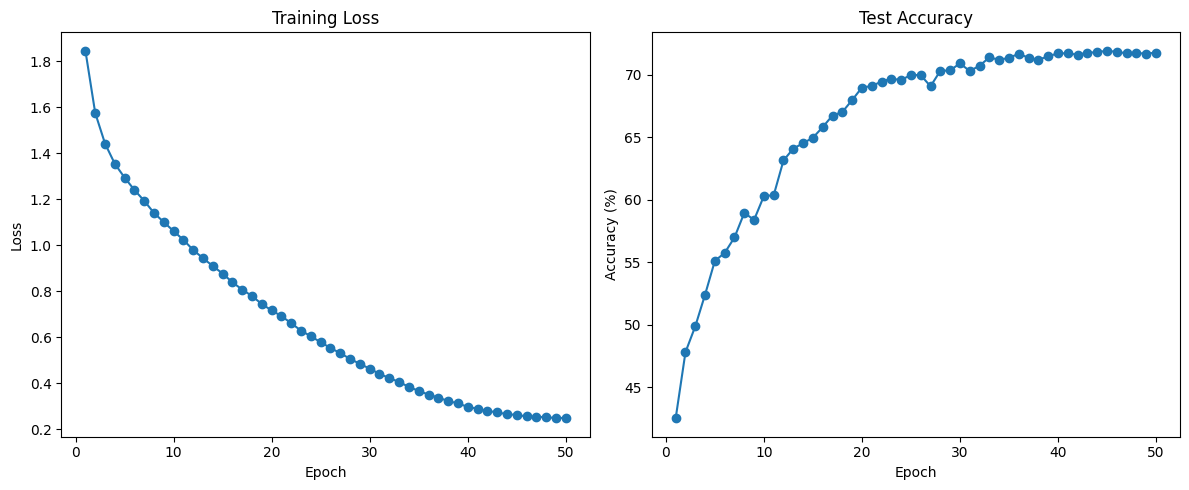

👉 Final Test Accuracy for patch size 2: 71.78%


In [28]:
model = VisionTransformer(
    num_classes=10,
    embed_size=256,       # token embedding dimension
    num_heads=4,          # attention heads (reduced for stability/generalization)
    num_layers=8,         # slightly deeper transformer
    patch_size=4,
    feedforward_dim=1024  # hidden dim in each MLP block
).to(device)

# Optimizer with weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Scheduler: Cosine Annealing over 50 epochs
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Training function now also takes scheduler
train_losses, test_accuracies = train_and_evaluate(
    model, train_loader, test_loader,
    criterion, optimizer, device,
    epochs=50,
    scheduler=scheduler  # Pass the scheduler into your train loop
)

# Plot results
plot_loss_and_accuracy(train_losses, test_accuracies, epochs=50)
print(f"👉 Final Test Accuracy for patch size {patch_size}: {test_accuracies[-1]:.2f}%")

In [29]:
model = VisionTransformer(
    num_classes=10,
    embed_size=256,
    num_heads=4,
    num_layers=8,
    patch_size=4,
    feedforward_dim=1024
).to(device)

model.load_state_dict(torch.load("best_vit_model.pth"))

C:\Users\SHARS\AppData\Local\Temp\ipykernel_24364\719324036.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_vit_model.pth"))


<All keys matched successfully>

In [30]:
# Freeze patch embedding
for param in model.patch_embed.parameters():
    param.requires_grad = False

# Freeze the first 3 transformer blocks
for i in range(3):
    for param in model.transformer.blocks[i].parameters():
        param.requires_grad = False

AttributeError: 'VisionTransformer' object has no attribute 'patch_embed'

In [31]:
model = VisionTransformer(
    num_classes=10,
    embed_size=256,
    num_heads=4,
    num_layers=8,
    patch_size=4,
    feedforward_dim=1024
).to(device)

# Load pretrained weights
model.load_state_dict(torch.load("best_vit_model.pth"))

# Freeze patch embedding layer (your conv1)
for param in model.conv1.parameters():
    param.requires_grad = False

# Freeze the first 3 transformer blocks
for i in range(3):
    for param in model.encoder_layers[i].parameters():
        param.requires_grad = False

C:\Users\SHARS\AppData\Local\Temp\ipykernel_24364\2845870961.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_vit_model.pth"))


In [32]:
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-5,
    weight_decay=0.01
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [33]:
train_losses, test_accuracies = train_and_evaluate(
    model, train_loader, test_loader,
    criterion, optimizer, device,
    epochs=20,
    scheduler=scheduler,
    save_path="finetuned_vit_model.pth"
)

Testing: 100%|██████████| 157/157 [00:02<00:00, 57.06batch/s, accuracy=71]  


✅ New best model saved at epoch 1 with 70.96% accuracy
Epoch [1/20] | Loss: 0.3336 | Test Accuracy: 70.96% | LR: 0.000050


Testing: 100%|██████████| 157/157 [00:02<00:00, 60.20batch/s, accuracy=70.9]


Epoch [2/20] | Loss: 0.3196 | Test Accuracy: 70.91% | LR: 0.000049


Testing: 100%|██████████| 157/157 [00:02<00:00, 58.15batch/s, accuracy=70.5]


Epoch [3/20] | Loss: 0.3138 | Test Accuracy: 70.46% | LR: 0.000047


Testing: 100%|██████████| 157/157 [00:02<00:00, 55.98batch/s, accuracy=70.2]


Epoch [4/20] | Loss: 0.2977 | Test Accuracy: 70.16% | LR: 0.000045


Testing: 100%|██████████| 157/157 [00:02<00:00, 55.86batch/s, accuracy=70.7]


Epoch [5/20] | Loss: 0.2914 | Test Accuracy: 70.73% | LR: 0.000043


Testing: 100%|██████████| 157/157 [00:02<00:00, 57.06batch/s, accuracy=70.2]


Epoch [6/20] | Loss: 0.2710 | Test Accuracy: 70.18% | LR: 0.000040


Testing: 100%|██████████| 157/157 [00:03<00:00, 52.21batch/s, accuracy=71]  


✅ New best model saved at epoch 7 with 70.97% accuracy
Epoch [7/20] | Loss: 0.2629 | Test Accuracy: 70.97% | LR: 0.000036


Testing: 100%|██████████| 157/157 [00:02<00:00, 53.69batch/s, accuracy=70.9]


Epoch [8/20] | Loss: 0.2442 | Test Accuracy: 70.90% | LR: 0.000033


Testing: 100%|██████████| 157/157 [00:03<00:00, 50.08batch/s, accuracy=71.3]


✅ New best model saved at epoch 9 with 71.30% accuracy
Epoch [9/20] | Loss: 0.2348 | Test Accuracy: 71.30% | LR: 0.000029


Testing: 100%|██████████| 157/157 [00:02<00:00, 53.18batch/s, accuracy=71.5]


✅ New best model saved at epoch 10 with 71.55% accuracy
Epoch [10/20] | Loss: 0.2209 | Test Accuracy: 71.55% | LR: 0.000025


Testing: 100%|██████████| 157/157 [00:03<00:00, 50.55batch/s, accuracy=71.6]


✅ New best model saved at epoch 11 with 71.62% accuracy
Epoch [11/20] | Loss: 0.2039 | Test Accuracy: 71.62% | LR: 0.000021


Testing: 100%|██████████| 157/157 [00:02<00:00, 52.84batch/s, accuracy=71.6]


Epoch [12/20] | Loss: 0.1955 | Test Accuracy: 71.57% | LR: 0.000017


Testing: 100%|██████████| 157/157 [00:03<00:00, 46.90batch/s, accuracy=71.4]


Epoch [13/20] | Loss: 0.1847 | Test Accuracy: 71.38% | LR: 0.000014


Testing: 100%|██████████| 157/157 [00:03<00:00, 50.57batch/s, accuracy=71.6]


✅ New best model saved at epoch 14 with 71.64% accuracy
Epoch [14/20] | Loss: 0.1719 | Test Accuracy: 71.64% | LR: 0.000010


Testing: 100%|██████████| 157/157 [00:02<00:00, 60.45batch/s, accuracy=71.7]


✅ New best model saved at epoch 15 with 71.72% accuracy
Epoch [15/20] | Loss: 0.1653 | Test Accuracy: 71.72% | LR: 0.000007


Testing: 100%|██████████| 157/157 [00:02<00:00, 66.34batch/s, accuracy=72]  


✅ New best model saved at epoch 16 with 72.00% accuracy
Epoch [16/20] | Loss: 0.1560 | Test Accuracy: 72.00% | LR: 0.000005


Testing: 100%|██████████| 157/157 [00:02<00:00, 62.93batch/s, accuracy=72]  


Epoch [17/20] | Loss: 0.1500 | Test Accuracy: 71.96% | LR: 0.000003


Testing: 100%|██████████| 157/157 [00:04<00:00, 32.30batch/s, accuracy=71.8]


Epoch [18/20] | Loss: 0.1476 | Test Accuracy: 71.84% | LR: 0.000001


Testing: 100%|██████████| 157/157 [00:02<00:00, 54.21batch/s, accuracy=71.9]


Epoch [19/20] | Loss: 0.1436 | Test Accuracy: 71.93% | LR: 0.000000


Testing: 100%|██████████| 157/157 [00:02<00:00, 55.29batch/s, accuracy=72]  


Epoch [20/20] | Loss: 0.1420 | Test Accuracy: 71.99% | LR: 0.000000


Testing: 100%|██████████| 157/157 [00:01<00:00, 95.25batch/s, accuracy=37.5]


✅ New best model saved at epoch 1 with 37.48% accuracy
Epoch [1/50] | Loss: 1.9283 | Test Accuracy: 37.48% | LR: 0.000999


Testing: 100%|██████████| 157/157 [00:01<00:00, 96.15batch/s, accuracy=43.6]


✅ New best model saved at epoch 2 with 43.59% accuracy
Epoch [2/50] | Loss: 1.5953 | Test Accuracy: 43.59% | LR: 0.000996


Testing: 100%|██████████| 157/157 [00:01<00:00, 98.97batch/s, accuracy=50.2] 


✅ New best model saved at epoch 3 with 50.17% accuracy
Epoch [3/50] | Loss: 1.4531 | Test Accuracy: 50.17% | LR: 0.000991


Testing: 100%|██████████| 157/157 [00:01<00:00, 96.95batch/s, accuracy=52.1]


✅ New best model saved at epoch 4 with 52.06% accuracy
Epoch [4/50] | Loss: 1.3768 | Test Accuracy: 52.06% | LR: 0.000984


Testing: 100%|██████████| 157/157 [00:01<00:00, 98.91batch/s, accuracy=54]   


✅ New best model saved at epoch 5 with 53.99% accuracy
Epoch [5/50] | Loss: 1.3141 | Test Accuracy: 53.99% | LR: 0.000976


Testing: 100%|██████████| 157/157 [00:02<00:00, 65.33batch/s, accuracy=53.9]


Epoch [6/50] | Loss: 1.2635 | Test Accuracy: 53.88% | LR: 0.000965


Testing: 100%|██████████| 157/157 [00:02<00:00, 63.69batch/s, accuracy=56.4]


✅ New best model saved at epoch 7 with 56.37% accuracy
Epoch [7/50] | Loss: 1.2173 | Test Accuracy: 56.37% | LR: 0.000952


Testing: 100%|██████████| 157/157 [00:01<00:00, 89.01batch/s, accuracy=58.2]


✅ New best model saved at epoch 8 with 58.22% accuracy
Epoch [8/50] | Loss: 1.1724 | Test Accuracy: 58.22% | LR: 0.000938


Testing: 100%|██████████| 157/157 [00:01<00:00, 80.89batch/s, accuracy=57.2]


Epoch [9/50] | Loss: 1.1334 | Test Accuracy: 57.22% | LR: 0.000922


Testing: 100%|██████████| 157/157 [00:01<00:00, 96.40batch/s, accuracy=60.7]


✅ New best model saved at epoch 10 with 60.68% accuracy
Epoch [10/50] | Loss: 1.1020 | Test Accuracy: 60.68% | LR: 0.000905


Testing: 100%|██████████| 157/157 [00:01<00:00, 97.64batch/s, accuracy=59.6]


Epoch [11/50] | Loss: 1.0761 | Test Accuracy: 59.63% | LR: 0.000885


Testing: 100%|██████████| 157/157 [00:01<00:00, 97.11batch/s, accuracy=62.3]


✅ New best model saved at epoch 12 with 62.26% accuracy
Epoch [12/50] | Loss: 1.0390 | Test Accuracy: 62.26% | LR: 0.000864


Testing: 100%|██████████| 157/157 [00:01<00:00, 86.49batch/s, accuracy=62.8]


✅ New best model saved at epoch 13 with 62.76% accuracy
Epoch [13/50] | Loss: 1.0108 | Test Accuracy: 62.76% | LR: 0.000842


Testing: 100%|██████████| 157/157 [00:01<00:00, 94.31batch/s, accuracy=63.9]


✅ New best model saved at epoch 14 with 63.89% accuracy
Epoch [14/50] | Loss: 0.9718 | Test Accuracy: 63.89% | LR: 0.000819


Testing: 100%|██████████| 157/157 [00:01<00:00, 94.78batch/s, accuracy=63.6]


Epoch [15/50] | Loss: 0.9468 | Test Accuracy: 63.59% | LR: 0.000794


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.35batch/s, accuracy=64.9]


✅ New best model saved at epoch 16 with 64.88% accuracy
Epoch [16/50] | Loss: 0.9133 | Test Accuracy: 64.88% | LR: 0.000768


Testing: 100%|██████████| 157/157 [00:02<00:00, 70.97batch/s, accuracy=64.5]


Epoch [17/50] | Loss: 0.8952 | Test Accuracy: 64.49% | LR: 0.000741


Testing: 100%|██████████| 157/157 [00:02<00:00, 75.38batch/s, accuracy=66.2]


✅ New best model saved at epoch 18 with 66.23% accuracy
Epoch [18/50] | Loss: 0.8713 | Test Accuracy: 66.23% | LR: 0.000713


Testing: 100%|██████████| 157/157 [00:01<00:00, 94.63batch/s, accuracy=65.1]


Epoch [19/50] | Loss: 0.8508 | Test Accuracy: 65.11% | LR: 0.000684


Testing: 100%|██████████| 157/157 [00:02<00:00, 76.49batch/s, accuracy=67.4]


✅ New best model saved at epoch 20 with 67.36% accuracy
Epoch [20/50] | Loss: 0.8273 | Test Accuracy: 67.36% | LR: 0.000655


Testing: 100%|██████████| 157/157 [00:02<00:00, 65.76batch/s, accuracy=66.6]


Epoch [21/50] | Loss: 0.8047 | Test Accuracy: 66.58% | LR: 0.000624


Testing: 100%|██████████| 157/157 [00:01<00:00, 98.37batch/s, accuracy=65.7] 


Epoch [22/50] | Loss: 0.7816 | Test Accuracy: 65.68% | LR: 0.000594


Testing: 100%|██████████| 157/157 [00:01<00:00, 94.60batch/s, accuracy=67]  


Epoch [23/50] | Loss: 0.7637 | Test Accuracy: 67.04% | LR: 0.000563


Testing: 100%|██████████| 157/157 [00:01<00:00, 99.50batch/s, accuracy=68.2] 


✅ New best model saved at epoch 24 with 68.16% accuracy
Epoch [24/50] | Loss: 0.7406 | Test Accuracy: 68.16% | LR: 0.000531


Testing: 100%|██████████| 157/157 [00:01<00:00, 99.75batch/s, accuracy=67.7] 


Epoch [25/50] | Loss: 0.7193 | Test Accuracy: 67.67% | LR: 0.000500


Testing: 100%|██████████| 157/157 [00:01<00:00, 100.19batch/s, accuracy=67.5]


Epoch [26/50] | Loss: 0.6941 | Test Accuracy: 67.46% | LR: 0.000469


Testing: 100%|██████████| 157/157 [00:01<00:00, 94.83batch/s, accuracy=67.9]


Epoch [27/50] | Loss: 0.6739 | Test Accuracy: 67.94% | LR: 0.000437


Testing: 100%|██████████| 157/157 [00:01<00:00, 101.43batch/s, accuracy=67.7]


Epoch [28/50] | Loss: 0.6593 | Test Accuracy: 67.71% | LR: 0.000406


Testing: 100%|██████████| 157/157 [00:01<00:00, 95.86batch/s, accuracy=69.1]


✅ New best model saved at epoch 29 with 69.08% accuracy
Epoch [29/50] | Loss: 0.6359 | Test Accuracy: 69.08% | LR: 0.000376


Testing: 100%|██████████| 157/157 [00:01<00:00, 98.79batch/s, accuracy=69]  


Epoch [30/50] | Loss: 0.6182 | Test Accuracy: 68.96% | LR: 0.000345


Testing: 100%|██████████| 157/157 [00:01<00:00, 97.38batch/s, accuracy=69.3]


✅ New best model saved at epoch 31 with 69.34% accuracy
Epoch [31/50] | Loss: 0.5972 | Test Accuracy: 69.34% | LR: 0.000316


Testing: 100%|██████████| 157/157 [00:02<00:00, 62.57batch/s, accuracy=70.2]


✅ New best model saved at epoch 32 with 70.25% accuracy
Epoch [32/50] | Loss: 0.5817 | Test Accuracy: 70.25% | LR: 0.000287


Testing: 100%|██████████| 157/157 [00:02<00:00, 74.99batch/s, accuracy=69.8]


Epoch [33/50] | Loss: 0.5553 | Test Accuracy: 69.76% | LR: 0.000259


Testing: 100%|██████████| 157/157 [00:01<00:00, 98.21batch/s, accuracy=69]  


Epoch [34/50] | Loss: 0.5393 | Test Accuracy: 69.01% | LR: 0.000232


Testing: 100%|██████████| 157/157 [00:01<00:00, 99.14batch/s, accuracy=70.1]


Epoch [35/50] | Loss: 0.5229 | Test Accuracy: 70.13% | LR: 0.000206


Testing: 100%|██████████| 157/157 [00:01<00:00, 99.76batch/s, accuracy=70]   


Epoch [36/50] | Loss: 0.5041 | Test Accuracy: 70.00% | LR: 0.000181


Testing: 100%|██████████| 157/157 [00:01<00:00, 100.82batch/s, accuracy=70.2]


Epoch [37/50] | Loss: 0.4867 | Test Accuracy: 70.23% | LR: 0.000158


Testing: 100%|██████████| 157/157 [00:01<00:00, 98.92batch/s, accuracy=70.8] 


✅ New best model saved at epoch 38 with 70.77% accuracy
Epoch [38/50] | Loss: 0.4688 | Test Accuracy: 70.77% | LR: 0.000136


Testing: 100%|██████████| 157/157 [00:01<00:00, 100.04batch/s, accuracy=70.5]


Epoch [39/50] | Loss: 0.4555 | Test Accuracy: 70.52% | LR: 0.000115


Testing: 100%|██████████| 157/157 [00:01<00:00, 93.65batch/s, accuracy=70.5]


Epoch [40/50] | Loss: 0.4460 | Test Accuracy: 70.53% | LR: 0.000095


Testing: 100%|██████████| 157/157 [00:01<00:00, 97.27batch/s, accuracy=70.1]


Epoch [41/50] | Loss: 0.4321 | Test Accuracy: 70.06% | LR: 0.000078


Testing: 100%|██████████| 157/157 [00:01<00:00, 101.40batch/s, accuracy=70.4]


Epoch [42/50] | Loss: 0.4211 | Test Accuracy: 70.38% | LR: 0.000062


Testing: 100%|██████████| 157/157 [00:01<00:00, 93.07batch/s, accuracy=70.5]


Epoch [43/50] | Loss: 0.4104 | Test Accuracy: 70.52% | LR: 0.000048


Testing: 100%|██████████| 157/157 [00:01<00:00, 96.23batch/s, accuracy=70.6]


Epoch [44/50] | Loss: 0.4035 | Test Accuracy: 70.56% | LR: 0.000035


Testing: 100%|██████████| 157/157 [00:01<00:00, 94.81batch/s, accuracy=70.7]


Epoch [45/50] | Loss: 0.3969 | Test Accuracy: 70.70% | LR: 0.000024


Testing: 100%|██████████| 157/157 [00:01<00:00, 97.38batch/s, accuracy=70.5]


Epoch [46/50] | Loss: 0.3919 | Test Accuracy: 70.49% | LR: 0.000016


Testing: 100%|██████████| 157/157 [00:02<00:00, 62.34batch/s, accuracy=70.5]


Epoch [47/50] | Loss: 0.3853 | Test Accuracy: 70.49% | LR: 0.000009


Testing: 100%|██████████| 157/157 [00:02<00:00, 68.84batch/s, accuracy=70.6]


Epoch [48/50] | Loss: 0.3820 | Test Accuracy: 70.64% | LR: 0.000004


Testing: 100%|██████████| 157/157 [00:02<00:00, 65.47batch/s, accuracy=70.5]


Epoch [49/50] | Loss: 0.3772 | Test Accuracy: 70.50% | LR: 0.000001


Testing: 100%|██████████| 157/157 [00:02<00:00, 77.69batch/s, accuracy=70.6]


Epoch [50/50] | Loss: 0.3739 | Test Accuracy: 70.56% | LR: 0.000000


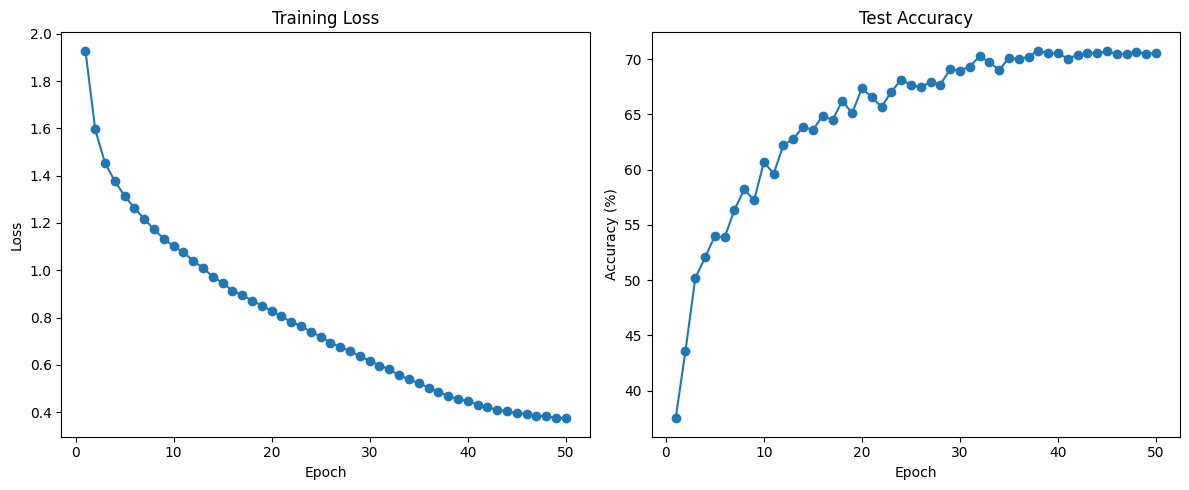

👉 Final Test Accuracy for patch size 2: 70.56%


In [36]:
model = VisionTransformer(
    num_classes=10,
    embed_size=128,
    num_heads=2,
    num_layers=4,
    patch_size=4,
    feedforward_dim=512
).to(device)


# Optimizer with weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Scheduler: Cosine Annealing over 50 epochs
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Training function now also takes scheduler
train_losses, test_accuracies = train_and_evaluate(
    model, train_loader, test_loader,
    criterion, optimizer, device,
    epochs=50,
    scheduler=scheduler  # Pass the scheduler into your train loop
)

# Plot results
plot_loss_and_accuracy(train_losses, test_accuracies, epochs=50)
print(f"👉 Final Test Accuracy for patch size {patch_size}: {test_accuracies[-1]:.2f}%")

still stuck in the 70s

DATA AUGMENTATION

In [37]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Updated data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),            # Random crop with padding
    transforms.RandomHorizontalFlip(),               # Random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                         std=[0.5, 0.5, 0.5])
])

# Keep test transform simple and consistent
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                         std=[0.5, 0.5, 0.5])
])

# Apply transforms
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Testing: 100%|██████████| 157/157 [00:02<00:00, 67.08batch/s, accuracy=34.8]


✅ New best model saved at epoch 1 with 34.84% accuracy
Epoch [1/50] | Loss: 1.9700 | Test Accuracy: 34.84% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:02<00:00, 63.99batch/s, accuracy=45.1]


✅ New best model saved at epoch 2 with 45.12% accuracy
Epoch [2/50] | Loss: 1.6942 | Test Accuracy: 45.12% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.30batch/s, accuracy=48.7]


✅ New best model saved at epoch 3 with 48.71% accuracy
Epoch [3/50] | Loss: 1.5568 | Test Accuracy: 48.71% | LR: 0.000099


Testing: 100%|██████████| 157/157 [00:02<00:00, 55.52batch/s, accuracy=48.6]


Epoch [4/50] | Loss: 1.4706 | Test Accuracy: 48.60% | LR: 0.000098


Testing: 100%|██████████| 157/157 [00:02<00:00, 63.97batch/s, accuracy=52.5]


✅ New best model saved at epoch 5 with 52.47% accuracy
Epoch [5/50] | Loss: 1.4014 | Test Accuracy: 52.47% | LR: 0.000098


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.64batch/s, accuracy=54.1]


✅ New best model saved at epoch 6 with 54.15% accuracy
Epoch [6/50] | Loss: 1.3442 | Test Accuracy: 54.15% | LR: 0.000096


Testing: 100%|██████████| 157/157 [00:02<00:00, 59.25batch/s, accuracy=55.1]


✅ New best model saved at epoch 7 with 55.13% accuracy
Epoch [7/50] | Loss: 1.2935 | Test Accuracy: 55.13% | LR: 0.000095


Testing: 100%|██████████| 157/157 [00:02<00:00, 62.82batch/s, accuracy=58.1]


✅ New best model saved at epoch 8 with 58.11% accuracy
Epoch [8/50] | Loss: 1.2563 | Test Accuracy: 58.11% | LR: 0.000094


Testing: 100%|██████████| 157/157 [00:02<00:00, 52.35batch/s, accuracy=56.6]


Epoch [9/50] | Loss: 1.2191 | Test Accuracy: 56.60% | LR: 0.000092


Testing: 100%|██████████| 157/157 [00:02<00:00, 63.61batch/s, accuracy=59.9]


✅ New best model saved at epoch 10 with 59.88% accuracy
Epoch [10/50] | Loss: 1.1867 | Test Accuracy: 59.88% | LR: 0.000090


Testing: 100%|██████████| 157/157 [00:02<00:00, 59.45batch/s, accuracy=60.3]


✅ New best model saved at epoch 11 with 60.26% accuracy
Epoch [11/50] | Loss: 1.1539 | Test Accuracy: 60.26% | LR: 0.000089


Testing: 100%|██████████| 157/157 [00:02<00:00, 65.10batch/s, accuracy=61.9]


✅ New best model saved at epoch 12 with 61.90% accuracy
Epoch [12/50] | Loss: 1.1245 | Test Accuracy: 61.90% | LR: 0.000086


Testing: 100%|██████████| 157/157 [00:02<00:00, 66.22batch/s, accuracy=62.8]


✅ New best model saved at epoch 13 with 62.81% accuracy
Epoch [13/50] | Loss: 1.0974 | Test Accuracy: 62.81% | LR: 0.000084


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.18batch/s, accuracy=63.5]


✅ New best model saved at epoch 14 with 63.55% accuracy
Epoch [14/50] | Loss: 1.0682 | Test Accuracy: 63.55% | LR: 0.000082


Testing: 100%|██████████| 157/157 [00:02<00:00, 67.50batch/s, accuracy=62.9]


Epoch [15/50] | Loss: 1.0421 | Test Accuracy: 62.85% | LR: 0.000079


Testing: 100%|██████████| 157/157 [00:02<00:00, 63.06batch/s, accuracy=64.6]


✅ New best model saved at epoch 16 with 64.60% accuracy
Epoch [16/50] | Loss: 1.0214 | Test Accuracy: 64.60% | LR: 0.000077


Testing: 100%|██████████| 157/157 [00:03<00:00, 42.70batch/s, accuracy=66.7]


✅ New best model saved at epoch 17 with 66.74% accuracy
Epoch [17/50] | Loss: 0.9933 | Test Accuracy: 66.74% | LR: 0.000074


Testing: 100%|██████████| 157/157 [00:03<00:00, 43.51batch/s, accuracy=65.7]


Epoch [18/50] | Loss: 0.9768 | Test Accuracy: 65.66% | LR: 0.000071


Testing: 100%|██████████| 157/157 [00:02<00:00, 61.65batch/s, accuracy=65.7]


Epoch [19/50] | Loss: 0.9550 | Test Accuracy: 65.70% | LR: 0.000068


Testing: 100%|██████████| 157/157 [00:02<00:00, 63.29batch/s, accuracy=67]  


✅ New best model saved at epoch 20 with 67.03% accuracy
Epoch [20/50] | Loss: 0.9407 | Test Accuracy: 67.03% | LR: 0.000065


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.36batch/s, accuracy=67.9]


✅ New best model saved at epoch 21 with 67.87% accuracy
Epoch [21/50] | Loss: 0.9265 | Test Accuracy: 67.87% | LR: 0.000062


Testing: 100%|██████████| 157/157 [00:02<00:00, 62.72batch/s, accuracy=68.1]


✅ New best model saved at epoch 22 with 68.06% accuracy
Epoch [22/50] | Loss: 0.9005 | Test Accuracy: 68.06% | LR: 0.000059


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.62batch/s, accuracy=68.2]


✅ New best model saved at epoch 23 with 68.18% accuracy
Epoch [23/50] | Loss: 0.8861 | Test Accuracy: 68.18% | LR: 0.000056


Testing: 100%|██████████| 157/157 [00:02<00:00, 57.60batch/s, accuracy=68.8]


✅ New best model saved at epoch 24 with 68.79% accuracy
Epoch [24/50] | Loss: 0.8785 | Test Accuracy: 68.79% | LR: 0.000053


Testing: 100%|██████████| 157/157 [00:02<00:00, 62.89batch/s, accuracy=69.4]


✅ New best model saved at epoch 25 with 69.43% accuracy
Epoch [25/50] | Loss: 0.8537 | Test Accuracy: 69.43% | LR: 0.000050


Testing: 100%|██████████| 157/157 [00:02<00:00, 60.60batch/s, accuracy=70]  


✅ New best model saved at epoch 26 with 69.98% accuracy
Epoch [26/50] | Loss: 0.8415 | Test Accuracy: 69.98% | LR: 0.000047


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.62batch/s, accuracy=69.7]


Epoch [27/50] | Loss: 0.8270 | Test Accuracy: 69.68% | LR: 0.000044


Testing: 100%|██████████| 157/157 [00:02<00:00, 62.91batch/s, accuracy=70]  


Epoch [28/50] | Loss: 0.8136 | Test Accuracy: 69.96% | LR: 0.000041


Testing: 100%|██████████| 157/157 [00:02<00:00, 55.81batch/s, accuracy=70.7]


✅ New best model saved at epoch 29 with 70.66% accuracy
Epoch [29/50] | Loss: 0.8003 | Test Accuracy: 70.66% | LR: 0.000038


Testing: 100%|██████████| 157/157 [00:02<00:00, 56.17batch/s, accuracy=70.8]


✅ New best model saved at epoch 30 with 70.83% accuracy
Epoch [30/50] | Loss: 0.7894 | Test Accuracy: 70.83% | LR: 0.000035


Testing: 100%|██████████| 157/157 [00:03<00:00, 52.10batch/s, accuracy=70.9]


✅ New best model saved at epoch 31 with 70.94% accuracy
Epoch [31/50] | Loss: 0.7707 | Test Accuracy: 70.94% | LR: 0.000032


Testing: 100%|██████████| 157/157 [00:02<00:00, 56.66batch/s, accuracy=71.4]


✅ New best model saved at epoch 32 with 71.43% accuracy
Epoch [32/50] | Loss: 0.7660 | Test Accuracy: 71.43% | LR: 0.000029


Testing: 100%|██████████| 157/157 [00:02<00:00, 59.92batch/s, accuracy=71.9]


✅ New best model saved at epoch 33 with 71.94% accuracy
Epoch [33/50] | Loss: 0.7542 | Test Accuracy: 71.94% | LR: 0.000026


Testing: 100%|██████████| 157/157 [00:02<00:00, 62.90batch/s, accuracy=72.1]


✅ New best model saved at epoch 34 with 72.07% accuracy
Epoch [34/50] | Loss: 0.7359 | Test Accuracy: 72.07% | LR: 0.000023


Testing: 100%|██████████| 157/157 [00:02<00:00, 56.51batch/s, accuracy=72.1]


✅ New best model saved at epoch 35 with 72.10% accuracy
Epoch [35/50] | Loss: 0.7261 | Test Accuracy: 72.10% | LR: 0.000021


Testing: 100%|██████████| 157/157 [00:02<00:00, 58.24batch/s, accuracy=72.2]


✅ New best model saved at epoch 36 with 72.25% accuracy
Epoch [36/50] | Loss: 0.7198 | Test Accuracy: 72.25% | LR: 0.000018


Testing: 100%|██████████| 157/157 [00:02<00:00, 62.19batch/s, accuracy=72.2]


Epoch [37/50] | Loss: 0.7109 | Test Accuracy: 72.15% | LR: 0.000016


Testing: 100%|██████████| 157/157 [00:02<00:00, 62.31batch/s, accuracy=72.5]


✅ New best model saved at epoch 38 with 72.45% accuracy
Epoch [38/50] | Loss: 0.7010 | Test Accuracy: 72.45% | LR: 0.000014


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.74batch/s, accuracy=72.5]


✅ New best model saved at epoch 39 with 72.52% accuracy
Epoch [39/50] | Loss: 0.6949 | Test Accuracy: 72.52% | LR: 0.000011


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.66batch/s, accuracy=72.8]


✅ New best model saved at epoch 40 with 72.76% accuracy
Epoch [40/50] | Loss: 0.6853 | Test Accuracy: 72.76% | LR: 0.000010


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.80batch/s, accuracy=72.7]


Epoch [41/50] | Loss: 0.6783 | Test Accuracy: 72.74% | LR: 0.000008


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.58batch/s, accuracy=73.3]


✅ New best model saved at epoch 42 with 73.27% accuracy
Epoch [42/50] | Loss: 0.6722 | Test Accuracy: 73.27% | LR: 0.000006


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.52batch/s, accuracy=73.5]


✅ New best model saved at epoch 43 with 73.53% accuracy
Epoch [43/50] | Loss: 0.6676 | Test Accuracy: 73.53% | LR: 0.000005


Testing: 100%|██████████| 157/157 [00:02<00:00, 65.18batch/s, accuracy=73.5]


Epoch [44/50] | Loss: 0.6643 | Test Accuracy: 73.50% | LR: 0.000004


Testing: 100%|██████████| 157/157 [00:02<00:00, 63.43batch/s, accuracy=73.3]


Epoch [45/50] | Loss: 0.6567 | Test Accuracy: 73.34% | LR: 0.000002


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.20batch/s, accuracy=73.5]


Epoch [46/50] | Loss: 0.6548 | Test Accuracy: 73.45% | LR: 0.000002


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.09batch/s, accuracy=73.4]


Epoch [47/50] | Loss: 0.6515 | Test Accuracy: 73.39% | LR: 0.000001


Testing: 100%|██████████| 157/157 [00:02<00:00, 62.89batch/s, accuracy=73.6]


✅ New best model saved at epoch 48 with 73.56% accuracy
Epoch [48/50] | Loss: 0.6490 | Test Accuracy: 73.56% | LR: 0.000000


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.72batch/s, accuracy=73.4]


Epoch [49/50] | Loss: 0.6509 | Test Accuracy: 73.42% | LR: 0.000000


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.88batch/s, accuracy=73.5]


Epoch [50/50] | Loss: 0.6489 | Test Accuracy: 73.50% | LR: 0.000000


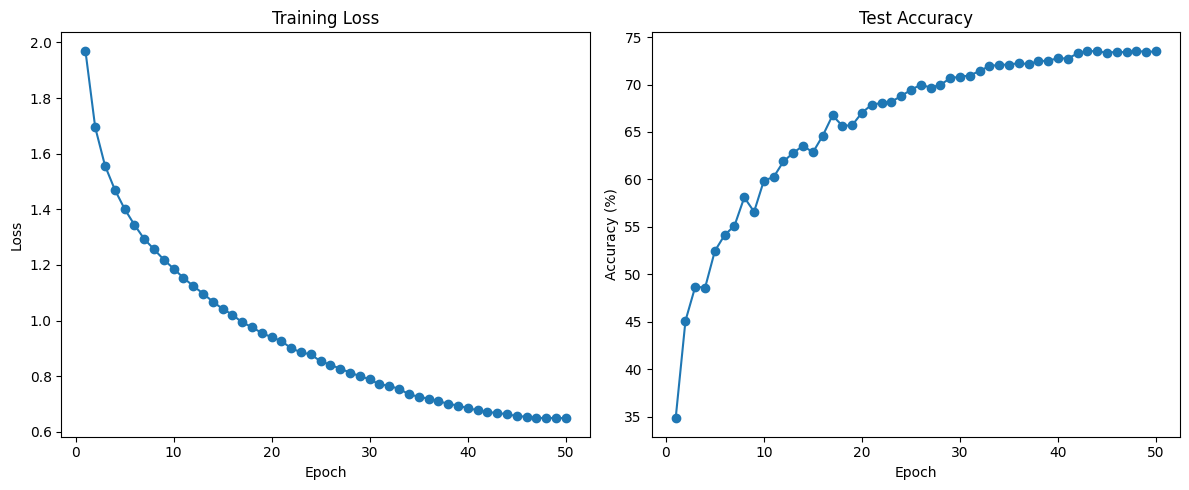

👉 Final Test Accuracy for patch size 2: 73.50%


In [39]:
model = VisionTransformer(
    num_classes=10,
    embed_size=256,       # token embedding dimension
    num_heads=4,          # attention heads (reduced for stability/generalization)
    num_layers=8,         # slightly deeper transformer
    patch_size=4,
    feedforward_dim=1024  # hidden dim in each MLP block
).to(device)

# Optimizer with weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Scheduler: Cosine Annealing over 50 epochs
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Training function now also takes scheduler
train_losses, test_accuracies = train_and_evaluate(
    model, train_loader, test_loader,
    criterion, optimizer, device,
    epochs=50,
    scheduler=scheduler  # Pass the scheduler into your train loop
)

# Plot results
plot_loss_and_accuracy(train_losses, test_accuracies, epochs=50)
print(f"👉 Final Test Accuracy for patch size {patch_size}: {test_accuracies[-1]:.2f}%")

73.56 with data augmentation random flip plus random crop

Testing: 100%|██████████| 157/157 [00:03<00:00, 49.35batch/s, accuracy=33.8]


✅ New best model saved at epoch 1 with 33.77% accuracy
Epoch [1/50] | Loss: 1.9917 | Test Accuracy: 33.77% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:03<00:00, 43.01batch/s, accuracy=41.7]


✅ New best model saved at epoch 2 with 41.68% accuracy
Epoch [2/50] | Loss: 1.7422 | Test Accuracy: 41.68% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:03<00:00, 39.80batch/s, accuracy=48.5]


✅ New best model saved at epoch 3 with 48.52% accuracy
Epoch [3/50] | Loss: 1.5912 | Test Accuracy: 48.52% | LR: 0.000099


Testing: 100%|██████████| 157/157 [00:04<00:00, 37.52batch/s, accuracy=49.7]


✅ New best model saved at epoch 4 with 49.71% accuracy
Epoch [4/50] | Loss: 1.4729 | Test Accuracy: 49.71% | LR: 0.000098


Testing: 100%|██████████| 157/157 [00:03<00:00, 47.80batch/s, accuracy=54.4]


✅ New best model saved at epoch 5 with 54.43% accuracy
Epoch [5/50] | Loss: 1.3849 | Test Accuracy: 54.43% | LR: 0.000098


Testing: 100%|██████████| 157/157 [00:03<00:00, 48.12batch/s, accuracy=54.8]


✅ New best model saved at epoch 6 with 54.77% accuracy
Epoch [6/50] | Loss: 1.3034 | Test Accuracy: 54.77% | LR: 0.000096


Testing: 100%|██████████| 157/157 [00:03<00:00, 44.93batch/s, accuracy=59.4]


✅ New best model saved at epoch 7 with 59.42% accuracy
Epoch [7/50] | Loss: 1.2456 | Test Accuracy: 59.42% | LR: 0.000095


Testing: 100%|██████████| 157/157 [00:03<00:00, 47.49batch/s, accuracy=58.6]


Epoch [8/50] | Loss: 1.1895 | Test Accuracy: 58.58% | LR: 0.000094


Testing: 100%|██████████| 157/157 [00:03<00:00, 47.86batch/s, accuracy=61]  


✅ New best model saved at epoch 9 with 61.03% accuracy
Epoch [9/50] | Loss: 1.1364 | Test Accuracy: 61.03% | LR: 0.000092


Testing: 100%|██████████| 157/157 [00:04<00:00, 36.80batch/s, accuracy=63.9]


✅ New best model saved at epoch 10 with 63.86% accuracy
Epoch [10/50] | Loss: 1.1008 | Test Accuracy: 63.86% | LR: 0.000090


Testing: 100%|██████████| 157/157 [00:03<00:00, 49.22batch/s, accuracy=63.7]


Epoch [11/50] | Loss: 1.0616 | Test Accuracy: 63.69% | LR: 0.000089


Testing: 100%|██████████| 157/157 [00:03<00:00, 46.75batch/s, accuracy=60.5]


Epoch [12/50] | Loss: 1.0319 | Test Accuracy: 60.51% | LR: 0.000086


Testing: 100%|██████████| 157/157 [00:04<00:00, 34.49batch/s, accuracy=66.2]


✅ New best model saved at epoch 13 with 66.22% accuracy
Epoch [13/50] | Loss: 0.9978 | Test Accuracy: 66.22% | LR: 0.000084


Testing: 100%|██████████| 157/157 [00:03<00:00, 48.92batch/s, accuracy=65.7]


Epoch [14/50] | Loss: 0.9728 | Test Accuracy: 65.72% | LR: 0.000082


Testing: 100%|██████████| 157/157 [00:03<00:00, 46.63batch/s, accuracy=65.6]


Epoch [15/50] | Loss: 0.9461 | Test Accuracy: 65.60% | LR: 0.000079


Testing: 100%|██████████| 157/157 [00:04<00:00, 33.98batch/s, accuracy=69]  


✅ New best model saved at epoch 16 with 69.01% accuracy
Epoch [16/50] | Loss: 0.9203 | Test Accuracy: 69.01% | LR: 0.000077


Testing: 100%|██████████| 157/157 [00:04<00:00, 39.24batch/s, accuracy=67.3]


Epoch [17/50] | Loss: 0.8983 | Test Accuracy: 67.33% | LR: 0.000074


Testing: 100%|██████████| 157/157 [00:05<00:00, 30.71batch/s, accuracy=69.2]


✅ New best model saved at epoch 18 with 69.20% accuracy
Epoch [18/50] | Loss: 0.8767 | Test Accuracy: 69.20% | LR: 0.000071


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.68batch/s, accuracy=71.3]


✅ New best model saved at epoch 19 with 71.28% accuracy
Epoch [19/50] | Loss: 0.8505 | Test Accuracy: 71.28% | LR: 0.000068


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.40batch/s, accuracy=70.3]


Epoch [20/50] | Loss: 0.8269 | Test Accuracy: 70.33% | LR: 0.000065


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.34batch/s, accuracy=72]  


✅ New best model saved at epoch 21 with 71.98% accuracy
Epoch [21/50] | Loss: 0.8011 | Test Accuracy: 71.98% | LR: 0.000062


Testing: 100%|██████████| 157/157 [00:04<00:00, 38.58batch/s, accuracy=72.1]


✅ New best model saved at epoch 22 with 72.07% accuracy
Epoch [22/50] | Loss: 0.7781 | Test Accuracy: 72.07% | LR: 0.000059


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.68batch/s, accuracy=73.1]


✅ New best model saved at epoch 23 with 73.07% accuracy
Epoch [23/50] | Loss: 0.7599 | Test Accuracy: 73.07% | LR: 0.000056


Testing: 100%|██████████| 157/157 [00:03<00:00, 41.06batch/s, accuracy=72.9]


Epoch [24/50] | Loss: 0.7352 | Test Accuracy: 72.87% | LR: 0.000053


Testing: 100%|██████████| 157/157 [00:04<00:00, 38.63batch/s, accuracy=73.9]


✅ New best model saved at epoch 25 with 73.87% accuracy
Epoch [25/50] | Loss: 0.7203 | Test Accuracy: 73.87% | LR: 0.000050


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.31batch/s, accuracy=74.4]


✅ New best model saved at epoch 26 with 74.43% accuracy
Epoch [26/50] | Loss: 0.6994 | Test Accuracy: 74.43% | LR: 0.000047


Testing: 100%|██████████| 157/157 [00:03<00:00, 42.05batch/s, accuracy=74.6]


✅ New best model saved at epoch 27 with 74.56% accuracy
Epoch [27/50] | Loss: 0.6764 | Test Accuracy: 74.56% | LR: 0.000044


Testing: 100%|██████████| 157/157 [00:03<00:00, 46.03batch/s, accuracy=74.9]


✅ New best model saved at epoch 28 with 74.89% accuracy
Epoch [28/50] | Loss: 0.6610 | Test Accuracy: 74.89% | LR: 0.000041


Testing: 100%|██████████| 157/157 [00:03<00:00, 45.59batch/s, accuracy=75.6]


✅ New best model saved at epoch 29 with 75.59% accuracy
Epoch [29/50] | Loss: 0.6393 | Test Accuracy: 75.59% | LR: 0.000038


Testing: 100%|██████████| 157/157 [00:03<00:00, 45.88batch/s, accuracy=75.2]


Epoch [30/50] | Loss: 0.6277 | Test Accuracy: 75.19% | LR: 0.000035


Testing: 100%|██████████| 157/157 [00:03<00:00, 45.27batch/s, accuracy=75.7]


✅ New best model saved at epoch 31 with 75.68% accuracy
Epoch [31/50] | Loss: 0.6128 | Test Accuracy: 75.68% | LR: 0.000032


Testing: 100%|██████████| 157/157 [00:03<00:00, 44.24batch/s, accuracy=76]  


✅ New best model saved at epoch 32 with 76.00% accuracy
Epoch [32/50] | Loss: 0.5926 | Test Accuracy: 76.00% | LR: 0.000029


Testing: 100%|██████████| 157/157 [00:03<00:00, 44.96batch/s, accuracy=76.9]


✅ New best model saved at epoch 33 with 76.87% accuracy
Epoch [33/50] | Loss: 0.5813 | Test Accuracy: 76.87% | LR: 0.000026


Testing: 100%|██████████| 157/157 [00:03<00:00, 45.14batch/s, accuracy=76.4]


Epoch [34/50] | Loss: 0.5677 | Test Accuracy: 76.40% | LR: 0.000023


Testing: 100%|██████████| 157/157 [00:07<00:00, 22.23batch/s, accuracy=77.2]


✅ New best model saved at epoch 35 with 77.22% accuracy
Epoch [35/50] | Loss: 0.5529 | Test Accuracy: 77.22% | LR: 0.000021


Testing: 100%|██████████| 157/157 [00:03<00:00, 48.66batch/s, accuracy=76.8]


Epoch [36/50] | Loss: 0.5418 | Test Accuracy: 76.85% | LR: 0.000018


Testing: 100%|██████████| 157/157 [00:03<00:00, 47.84batch/s, accuracy=77.3]


✅ New best model saved at epoch 37 with 77.30% accuracy
Epoch [37/50] | Loss: 0.5248 | Test Accuracy: 77.30% | LR: 0.000016


Testing: 100%|██████████| 157/157 [00:03<00:00, 48.04batch/s, accuracy=77]  


Epoch [38/50] | Loss: 0.5188 | Test Accuracy: 76.97% | LR: 0.000014


Testing: 100%|██████████| 157/157 [00:03<00:00, 48.22batch/s, accuracy=77.5]


✅ New best model saved at epoch 39 with 77.48% accuracy
Epoch [39/50] | Loss: 0.5072 | Test Accuracy: 77.48% | LR: 0.000011


Testing: 100%|██████████| 157/157 [00:03<00:00, 48.85batch/s, accuracy=77.7]


✅ New best model saved at epoch 40 with 77.71% accuracy
Epoch [40/50] | Loss: 0.4961 | Test Accuracy: 77.71% | LR: 0.000010


Testing: 100%|██████████| 157/157 [00:03<00:00, 48.50batch/s, accuracy=77.8]


✅ New best model saved at epoch 41 with 77.81% accuracy
Epoch [41/50] | Loss: 0.4944 | Test Accuracy: 77.81% | LR: 0.000008


Testing: 100%|██████████| 157/157 [00:03<00:00, 48.01batch/s, accuracy=77.6]


Epoch [42/50] | Loss: 0.4819 | Test Accuracy: 77.59% | LR: 0.000006


Testing: 100%|██████████| 157/157 [00:03<00:00, 47.05batch/s, accuracy=77.5]


Epoch [43/50] | Loss: 0.4766 | Test Accuracy: 77.49% | LR: 0.000005


Testing: 100%|██████████| 157/157 [00:03<00:00, 48.43batch/s, accuracy=77.9]


✅ New best model saved at epoch 44 with 77.88% accuracy
Epoch [44/50] | Loss: 0.4672 | Test Accuracy: 77.88% | LR: 0.000004


Testing: 100%|██████████| 157/157 [00:03<00:00, 47.89batch/s, accuracy=78]  


✅ New best model saved at epoch 45 with 78.05% accuracy
Epoch [45/50] | Loss: 0.4651 | Test Accuracy: 78.05% | LR: 0.000002


Testing: 100%|██████████| 157/157 [00:03<00:00, 45.11batch/s, accuracy=77.7]


Epoch [46/50] | Loss: 0.4587 | Test Accuracy: 77.71% | LR: 0.000002


Testing: 100%|██████████| 157/157 [00:03<00:00, 48.01batch/s, accuracy=77.9]


Epoch [47/50] | Loss: 0.4583 | Test Accuracy: 77.94% | LR: 0.000001


Testing: 100%|██████████| 157/157 [00:03<00:00, 47.83batch/s, accuracy=78.1]


✅ New best model saved at epoch 48 with 78.06% accuracy
Epoch [48/50] | Loss: 0.4536 | Test Accuracy: 78.06% | LR: 0.000000


Testing: 100%|██████████| 157/157 [00:03<00:00, 48.34batch/s, accuracy=78]  


Epoch [49/50] | Loss: 0.4542 | Test Accuracy: 78.01% | LR: 0.000000


Testing: 100%|██████████| 157/157 [00:03<00:00, 47.51batch/s, accuracy=78]  


Epoch [50/50] | Loss: 0.4558 | Test Accuracy: 78.05% | LR: 0.000000


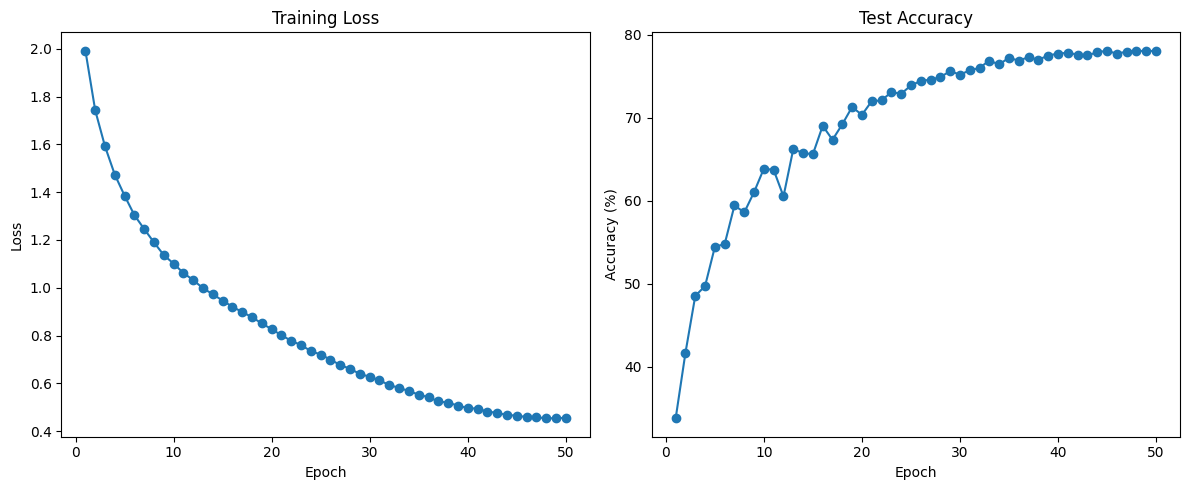

👉 Final Test Accuracy for patch size 2: 78.05%


In [42]:
model = VisionTransformer(
    num_classes=10,
    embed_size=256,       # token embedding dimension
    num_heads=8,          # attention heads (reduced for stability/generalization)
    num_layers=12,         # slightly deeper transformer
    patch_size=4,
    feedforward_dim=1024  # hidden dim in each MLP block
).to(device)

# Optimizer with weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Scheduler: Cosine Annealing over 50 epochs
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Training function now also takes scheduler
train_losses, test_accuracies = train_and_evaluate(
    model, train_loader, test_loader,
    criterion, optimizer, device,
    epochs=50,
    scheduler=scheduler,
    save_path="best_vit_deep.pth"# Pass the scheduler into your train loop
)

# Plot results
plot_loss_and_accuracy(train_losses, test_accuracies, epochs=50)
print(f"👉 Final Test Accuracy for patch size {patch_size}: {test_accuracies[-1]:.2f}%")

final best result was 78.06% unfortunately i couldnt crack the 80% benchmark and I have to stop here because of limited compute 

Now to positional embeddings

In [75]:
class VisionTransformer(nn.Module):
    def __init__(self, num_classes, embed_size=256, num_heads=8, num_layers=6,
                 patch_size=4, feedforward_dim=1024, image_size=32,
                 positional_embedding_type="1d_learned"):  # Options: none, 1d_learned, 2d_learned, sinusoidal
        super(VisionTransformer, self).__init__()

        self.patch_size = patch_size
        self.embed_size = embed_size
        self.image_size = image_size
        self.num_patches = (image_size // patch_size) ** 2
        self.seq_len = self.num_patches + 1
        self.positional_embedding_type = positional_embedding_type

        self.conv1 = nn.Conv2d(3, embed_size, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_size))

        # Positional embedding
        if positional_embedding_type == "1d_learned":
            self.pos_embed = nn.Parameter(torch.randn(1, self.seq_len, embed_size))
        elif positional_embedding_type == "2d_learned":
            grid_size = image_size // patch_size
            self.pos_embed_2d = nn.Parameter(torch.randn(1, grid_size, grid_size, embed_size))
        elif positional_embedding_type == "sinusoidal":
            self.register_buffer("pos_embed", self.sinusoidal_embedding(self.seq_len, embed_size))
        else:  # none
            self.pos_embed = None

        self.encoder_layers = nn.ModuleList([
            TransformerEncoderBlock(embed_size, num_heads, feedforward_dim) for _ in range(num_layers)
        ])

        self.fc = nn.Linear(embed_size, num_classes)

    def sinusoidal_embedding(self, seq_len, dim):
        pe = torch.zeros(seq_len, dim)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2).float() * (-np.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x):
        x = self.conv1(x)
        x = x.flatten(2).transpose(1, 2)

        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        if self.positional_embedding_type == "1d_learned":
            x = x + self.pos_embed
        elif self.positional_embedding_type == "2d_learned":
            B, _, _ = x.shape
            grid_size = self.image_size // self.patch_size
            pos_2d = self.pos_embed_2d.view(1, grid_size * grid_size, self.embed_size)
            pos = torch.cat([torch.zeros(1, 1, self.embed_size, device=x.device), pos_2d], dim=1)
            x = x + pos
        elif self.positional_embedding_type == "sinusoidal":
            x = x + self.pos_embed

        for layer in self.encoder_layers:
            x = layer(x)

        cls_output = x[:, 0]
        return self.fc(cls_output)


🔁 Training with positional embedding type: none



Testing: 100%|██████████| 157/157 [00:01<00:00, 105.85batch/s, accuracy=35.2]


✅ New best model saved at epoch 1 with 35.18% accuracy
Epoch [1/10] | Loss: 1.8732 | Test Accuracy: 35.18% | LR: 0.000098


Testing: 100%|██████████| 157/157 [00:01<00:00, 106.81batch/s, accuracy=42.1]


✅ New best model saved at epoch 2 with 42.09% accuracy
Epoch [2/10] | Loss: 1.6382 | Test Accuracy: 42.09% | LR: 0.000090


Testing: 100%|██████████| 157/157 [00:01<00:00, 103.99batch/s, accuracy=45.7]


✅ New best model saved at epoch 3 with 45.71% accuracy
Epoch [3/10] | Loss: 1.5046 | Test Accuracy: 45.71% | LR: 0.000079


Testing: 100%|██████████| 157/157 [00:01<00:00, 106.82batch/s, accuracy=50.2]


✅ New best model saved at epoch 4 with 50.21% accuracy
Epoch [4/10] | Loss: 1.4225 | Test Accuracy: 50.21% | LR: 0.000065


Testing: 100%|██████████| 157/157 [00:01<00:00, 105.17batch/s, accuracy=51.6]


✅ New best model saved at epoch 5 with 51.61% accuracy
Epoch [5/10] | Loss: 1.3508 | Test Accuracy: 51.61% | LR: 0.000050


Testing: 100%|██████████| 157/157 [00:01<00:00, 104.82batch/s, accuracy=53.9]


✅ New best model saved at epoch 6 with 53.89% accuracy
Epoch [6/10] | Loss: 1.3099 | Test Accuracy: 53.89% | LR: 0.000035


Testing: 100%|██████████| 157/157 [00:01<00:00, 103.53batch/s, accuracy=55.2]


✅ New best model saved at epoch 7 with 55.25% accuracy
Epoch [7/10] | Loss: 1.2742 | Test Accuracy: 55.25% | LR: 0.000021


Testing: 100%|██████████| 157/157 [00:01<00:00, 104.48batch/s, accuracy=55.7]


✅ New best model saved at epoch 8 with 55.66% accuracy
Epoch [8/10] | Loss: 1.2520 | Test Accuracy: 55.66% | LR: 0.000010


Testing: 100%|██████████| 157/157 [00:01<00:00, 101.04batch/s, accuracy=55.7]


✅ New best model saved at epoch 9 with 55.71% accuracy
Epoch [9/10] | Loss: 1.2336 | Test Accuracy: 55.71% | LR: 0.000002


Testing: 100%|██████████| 157/157 [00:01<00:00, 102.96batch/s, accuracy=55.7]


Epoch [10/10] | Loss: 1.2231 | Test Accuracy: 55.69% | LR: 0.000000


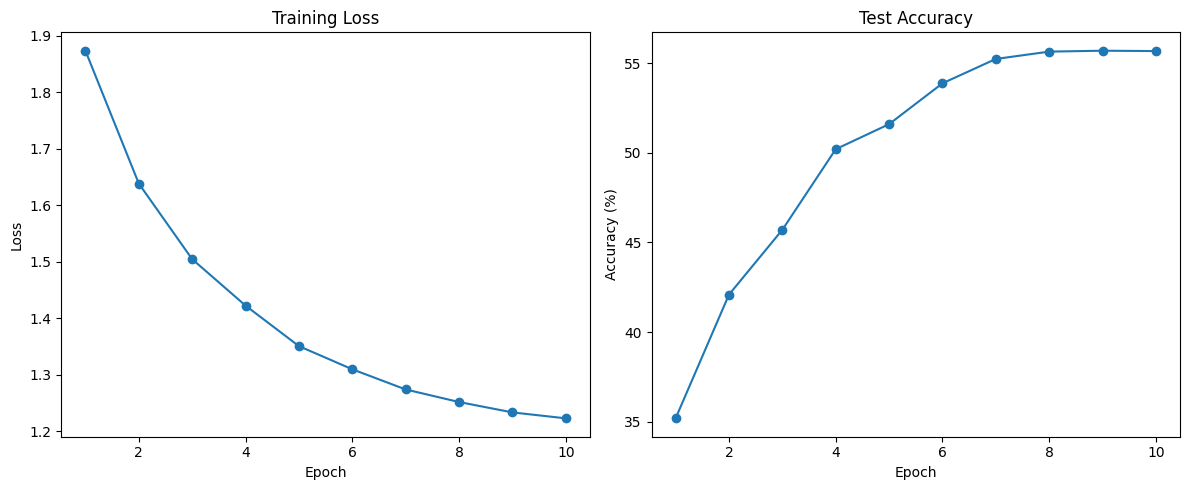

✅ Final Test Accuracy (none): 55.69%

🔁 Training with positional embedding type: 1d_learned



Testing: 100%|██████████| 157/157 [00:01<00:00, 99.90batch/s, accuracy=32.1]


✅ New best model saved at epoch 1 with 32.14% accuracy
Epoch [1/10] | Loss: 2.0078 | Test Accuracy: 32.14% | LR: 0.000098


Testing: 100%|██████████| 157/157 [00:01<00:00, 99.72batch/s, accuracy=39.6] 


✅ New best model saved at epoch 2 with 39.61% accuracy
Epoch [2/10] | Loss: 1.8206 | Test Accuracy: 39.61% | LR: 0.000090


Testing: 100%|██████████| 157/157 [00:01<00:00, 95.71batch/s, accuracy=43.6]


✅ New best model saved at epoch 3 with 43.56% accuracy
Epoch [3/10] | Loss: 1.7136 | Test Accuracy: 43.56% | LR: 0.000079


Testing: 100%|██████████| 157/157 [00:01<00:00, 97.60batch/s, accuracy=44.2]


✅ New best model saved at epoch 4 with 44.24% accuracy
Epoch [4/10] | Loss: 1.6377 | Test Accuracy: 44.24% | LR: 0.000065


Testing: 100%|██████████| 157/157 [00:01<00:00, 97.02batch/s, accuracy=45.8]


✅ New best model saved at epoch 5 with 45.78% accuracy
Epoch [5/10] | Loss: 1.5876 | Test Accuracy: 45.78% | LR: 0.000050


Testing: 100%|██████████| 157/157 [00:01<00:00, 94.61batch/s, accuracy=48.1]


✅ New best model saved at epoch 6 with 48.09% accuracy
Epoch [6/10] | Loss: 1.5481 | Test Accuracy: 48.09% | LR: 0.000035


Testing: 100%|██████████| 157/157 [00:01<00:00, 96.29batch/s, accuracy=49.6]


✅ New best model saved at epoch 7 with 49.56% accuracy
Epoch [7/10] | Loss: 1.5167 | Test Accuracy: 49.56% | LR: 0.000021


Testing: 100%|██████████| 157/157 [00:01<00:00, 96.39batch/s, accuracy=49.1]


Epoch [8/10] | Loss: 1.4941 | Test Accuracy: 49.11% | LR: 0.000010


Testing: 100%|██████████| 157/157 [00:01<00:00, 96.18batch/s, accuracy=50.1]


✅ New best model saved at epoch 9 with 50.15% accuracy
Epoch [9/10] | Loss: 1.4744 | Test Accuracy: 50.15% | LR: 0.000002


Testing: 100%|██████████| 157/157 [00:01<00:00, 98.16batch/s, accuracy=50.1]


Epoch [10/10] | Loss: 1.4694 | Test Accuracy: 50.10% | LR: 0.000000


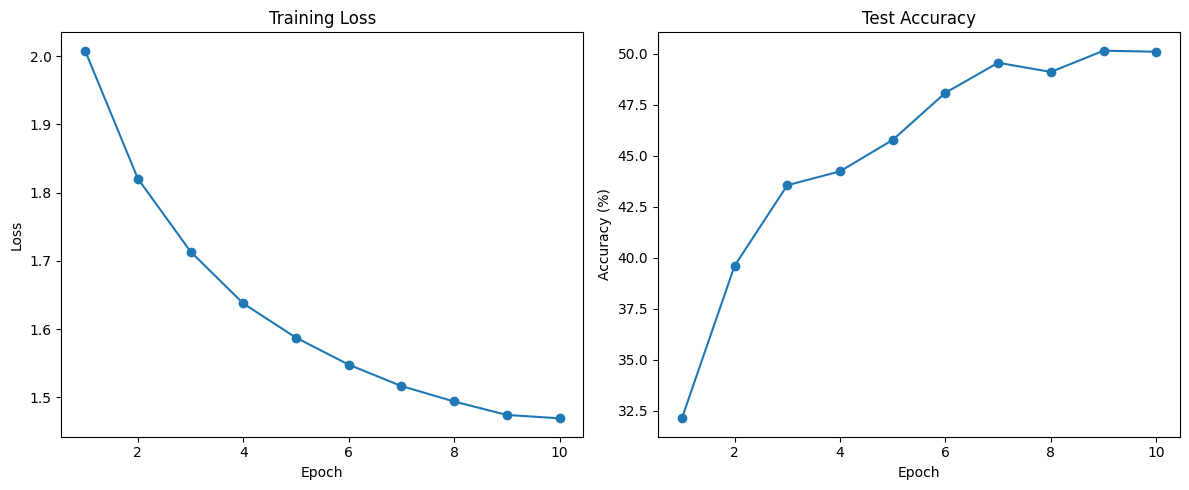

✅ Final Test Accuracy (1d_learned): 50.10%

🔁 Training with positional embedding type: 2d_learned



Testing: 100%|██████████| 157/157 [00:01<00:00, 95.67batch/s, accuracy=32.3]


✅ New best model saved at epoch 1 with 32.31% accuracy
Epoch [1/10] | Loss: 2.0192 | Test Accuracy: 32.31% | LR: 0.000098


Testing: 100%|██████████| 157/157 [00:01<00:00, 91.53batch/s, accuracy=38.9]


✅ New best model saved at epoch 2 with 38.86% accuracy
Epoch [2/10] | Loss: 1.8259 | Test Accuracy: 38.86% | LR: 0.000090


Testing: 100%|██████████| 157/157 [00:01<00:00, 96.33batch/s, accuracy=43.8]


✅ New best model saved at epoch 3 with 43.77% accuracy
Epoch [3/10] | Loss: 1.7152 | Test Accuracy: 43.77% | LR: 0.000079


Testing: 100%|██████████| 157/157 [00:01<00:00, 96.46batch/s, accuracy=45.2]


✅ New best model saved at epoch 4 with 45.21% accuracy
Epoch [4/10] | Loss: 1.6259 | Test Accuracy: 45.21% | LR: 0.000065


Testing: 100%|██████████| 157/157 [00:01<00:00, 97.81batch/s, accuracy=47]   


✅ New best model saved at epoch 5 with 46.96% accuracy
Epoch [5/10] | Loss: 1.5688 | Test Accuracy: 46.96% | LR: 0.000050


Testing: 100%|██████████| 157/157 [00:01<00:00, 93.57batch/s, accuracy=49]  


✅ New best model saved at epoch 6 with 48.97% accuracy
Epoch [6/10] | Loss: 1.5223 | Test Accuracy: 48.97% | LR: 0.000035


Testing: 100%|██████████| 157/157 [00:01<00:00, 96.84batch/s, accuracy=49.6]


✅ New best model saved at epoch 7 with 49.63% accuracy
Epoch [7/10] | Loss: 1.4915 | Test Accuracy: 49.63% | LR: 0.000021


Testing: 100%|██████████| 157/157 [00:01<00:00, 97.18batch/s, accuracy=50.6]


✅ New best model saved at epoch 8 with 50.60% accuracy
Epoch [8/10] | Loss: 1.4673 | Test Accuracy: 50.60% | LR: 0.000010


Testing: 100%|██████████| 157/157 [00:01<00:00, 99.16batch/s, accuracy=50.9] 


✅ New best model saved at epoch 9 with 50.93% accuracy
Epoch [9/10] | Loss: 1.4511 | Test Accuracy: 50.93% | LR: 0.000002


Testing: 100%|██████████| 157/157 [00:01<00:00, 96.65batch/s, accuracy=50.9]


Epoch [10/10] | Loss: 1.4460 | Test Accuracy: 50.90% | LR: 0.000000


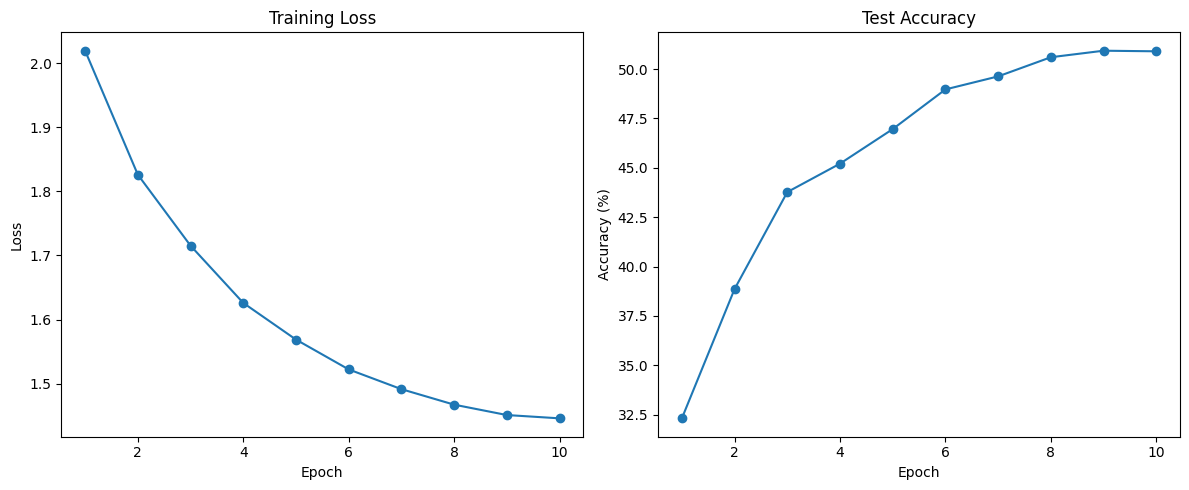

✅ Final Test Accuracy (2d_learned): 50.90%

🔁 Training with positional embedding type: sinusoidal



Testing: 100%|██████████| 157/157 [00:01<00:00, 93.70batch/s, accuracy=37.8]


✅ New best model saved at epoch 1 with 37.81% accuracy
Epoch [1/10] | Loss: 1.9496 | Test Accuracy: 37.81% | LR: 0.000098


Testing: 100%|██████████| 157/157 [00:01<00:00, 96.15batch/s, accuracy=44.3]


✅ New best model saved at epoch 2 with 44.26% accuracy
Epoch [2/10] | Loss: 1.6930 | Test Accuracy: 44.26% | LR: 0.000090


Testing: 100%|██████████| 157/157 [00:01<00:00, 98.78batch/s, accuracy=46.8] 


✅ New best model saved at epoch 3 with 46.80% accuracy
Epoch [3/10] | Loss: 1.5747 | Test Accuracy: 46.80% | LR: 0.000079


Testing: 100%|██████████| 157/157 [00:01<00:00, 88.60batch/s, accuracy=49]  


✅ New best model saved at epoch 4 with 49.01% accuracy
Epoch [4/10] | Loss: 1.4981 | Test Accuracy: 49.01% | LR: 0.000065


Testing: 100%|██████████| 157/157 [00:01<00:00, 92.78batch/s, accuracy=51.3]


✅ New best model saved at epoch 5 with 51.32% accuracy
Epoch [5/10] | Loss: 1.4423 | Test Accuracy: 51.32% | LR: 0.000050


Testing: 100%|██████████| 157/157 [00:01<00:00, 95.32batch/s, accuracy=50.6]


Epoch [6/10] | Loss: 1.4040 | Test Accuracy: 50.60% | LR: 0.000035


Testing: 100%|██████████| 157/157 [00:01<00:00, 94.01batch/s, accuracy=52.4]


✅ New best model saved at epoch 7 with 52.38% accuracy
Epoch [7/10] | Loss: 1.3724 | Test Accuracy: 52.38% | LR: 0.000021


Testing: 100%|██████████| 157/157 [00:01<00:00, 94.03batch/s, accuracy=53.4]


✅ New best model saved at epoch 8 with 53.41% accuracy
Epoch [8/10] | Loss: 1.3444 | Test Accuracy: 53.41% | LR: 0.000010


Testing: 100%|██████████| 157/157 [00:01<00:00, 96.00batch/s, accuracy=54.2]


✅ New best model saved at epoch 9 with 54.24% accuracy
Epoch [9/10] | Loss: 1.3235 | Test Accuracy: 54.24% | LR: 0.000002


Testing: 100%|██████████| 157/157 [00:02<00:00, 72.60batch/s, accuracy=54.4]


✅ New best model saved at epoch 10 with 54.41% accuracy
Epoch [10/10] | Loss: 1.3178 | Test Accuracy: 54.41% | LR: 0.000000


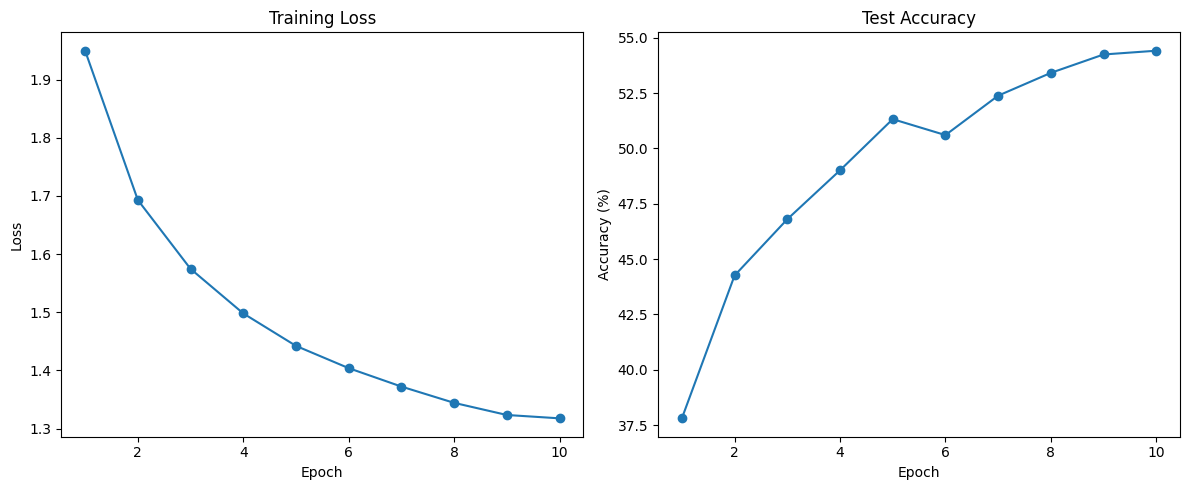

✅ Final Test Accuracy (sinusoidal): 54.41%

📊 Summary of Final Accuracies:
none: 55.69%
1d_learned: 50.10%
2d_learned: 50.90%
sinusoidal: 54.41%


In [45]:
embedding_types = ["none", "1d_learned", "2d_learned", "sinusoidal"]
results = {}

for emb_type in embedding_types:
    print(f"\n🔁 Training with positional embedding type: {emb_type}\n")
    
    model = VisionTransformer(
        num_classes=10,
        embed_size=128,
        num_heads=4,
        num_layers=6,
        patch_size=4,
        feedforward_dim=512,
        positional_embedding_type=emb_type
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

    save_path = f"best_vit_{emb_type}.pth"
    
    train_losses, test_accuracies = train_and_evaluate(
        model, train_loader, test_loader,
        criterion, optimizer, device,
        epochs=10,
        scheduler=scheduler,
        save_path=save_path
    )

    results[emb_type] = {
        "train_losses": train_losses,
        "test_accuracies": test_accuracies
    }

    plot_loss_and_accuracy(train_losses, test_accuracies, epochs=10)
    print(f"✅ Final Test Accuracy ({emb_type}): {test_accuracies[-1]:.2f}%")

# Optional: Print all final results
print("\n📊 Summary of Final Accuracies:")
for k in results:
    print(f"{k}: {results[k]['test_accuracies'][-1]:.2f}%")

🔍 Evaluating none positional embedding...


C:\Users\SHARS\AppData\Local\Temp\ipykernel_24364\4135597680.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_vit_{emb_type}.pth"

✅ none: 55.71%
🔍 Evaluating 1d_learned positional embedding...
✅ 1d_learned: 50.15%
🔍 Evaluating 2d_learned positional embedding...
✅ 2d_learned: 50.93%
🔍 Evaluating sinusoidal positional embedding...
✅ sinusoidal: 54.41%


C:\Users\SHARS\AppData\Local\Temp\ipykernel_24364\4135597680.py:48: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SHARS\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


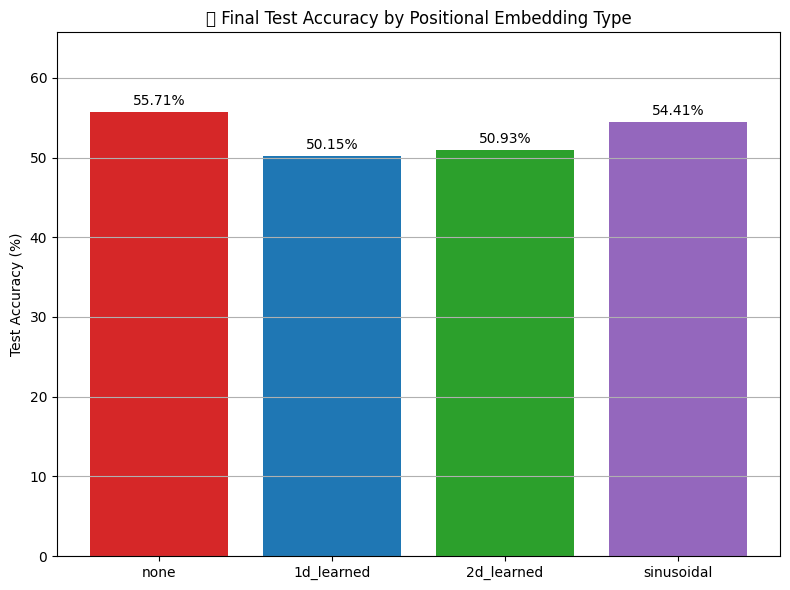

In [48]:
import torch
import matplotlib.pyplot as plt

embedding_types = ["none", "1d_learned", "2d_learned", "sinusoidal"]
accuracies = []

for emb_type in embedding_types:
    print(f"🔍 Evaluating {emb_type} positional embedding...")

    model = VisionTransformer(
        num_classes=10,
        embed_size=128,
        num_heads=4,
        num_layers=6,
        patch_size=4,
        feedforward_dim=512,
        positional_embedding_type=emb_type
    ).to(device)

    model.load_state_dict(torch.load(f"best_vit_{emb_type}.pth"))
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    print(f"✅ {emb_type}: {accuracy:.2f}%")

# Plotting final test accuracies
plt.figure(figsize=(8, 6))
colors = ['#d62728', '#1f77b4', '#2ca02c', '#9467bd']
plt.bar(embedding_types, accuracies, color=colors)
plt.ylabel("Test Accuracy (%)")
plt.title("📊 Final Test Accuracy by Positional Embedding Type")
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.5, f"{acc:.2f}%", ha='center', va='bottom')
plt.ylim(0, max(accuracies) + 10)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [49]:
import torch
import torchvision
from torchvision import transforms as pth_transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import vision_transformer as vits  # from DINO repo
import utils  # from DINO repo

# ----- CONFIG -----
arch = 'vit_small'
patch_size = 8
pretrained_url = "https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_300ep_pretrain.pth"
image_paths = [
    "img",  # Local image file path for img
    "img2"  # Local image file path for img2
]
image_size = (480, 480)
threshold = 0.6  # optional; comment out if not needed

# ----- SETUP -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = vits.__dict__[arch](patch_size=patch_size, num_classes=0)
for p in model.parameters():
    p.requires_grad = False
model.eval()
model.to(device)

# Load pretrained weights
state_dict = torch.hub.load_state_dict_from_url(url=pretrained_url, map_location="cpu")
model.load_state_dict(state_dict, strict=True)

# Transform
transform = pth_transforms.Compose([
    pth_transforms.Resize(image_size),
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# ----- VISUALIZE FUNCTION -----
def visualize_attention(image_path, index=0):
    # Load the image from the local path
    img = Image.open(image_path).convert("RGB")
    img_t = transform(img)
    
    # Ensure divisibility
    w, h = img_t.shape[1] - img_t.shape[1] % patch_size, img_t.shape[2] - img_t.shape[2] % patch_size
    img_t = img_t[:, :w, :h].unsqueeze(0).to(device)

    with torch.no_grad():
        attentions = model.get_last_selfattention(img_t)

    nh = attentions.shape[1]
    w_featmap = img_t.shape[-2] // patch_size
    h_featmap = img_t.shape[-1] // patch_size

    attn = attentions[0, :, 0, 1:].reshape(nh, -1)
    attn = attn.reshape(nh, w_featmap, h_featmap)
    attn = torch.nn.functional.interpolate(attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

    fig, axs = plt.subplots(1, nh, figsize=(20, 5))
    for i in range(nh):
        axs[i].imshow(attn[i], cmap='inferno')
        axs[i].axis('off')
        axs[i].set_title(f'Head {i}')
    plt.suptitle(f"Attention maps for Image {index}")
    plt.show()

# ----- RUN -----
for i, img_path in enumerate(image_paths):
    visualize_attention(img_path, i)


ModuleNotFoundError: No module named 'vision_transformer'

In [ ]:
!python visualize_attention.py \
   --arch vit_small \
   --patch_size 8 \
   --pretrained_weights weights/dino_deitsmall8.pth \
   --checkpoint_key teacher \
   --image_path C:..img.png \
   --output_dir C:/path/to/your/local/output1 \
   --threshold 0.6

Pretrained weights found at weights/dino_deitsmall8.pth and loaded with msg: <All keys matched successfully>
Provided image path C:/path/to/your/local/img1.jpg is non valid.


c:\Users\SHARS\OneDrive\문서\GitHub\assignment-5-HarshvardhanSingh841\dino\visualize_attention.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ar

In [63]:
!python visualize_attention.py \
  --arch vit_small \
  --patch_size 8 \
  --pretrained_weights weights/dino_deitsmall8.pth \
  --checkpoint_key teacher \
  --image_path img.png \
  --output_dir ./output1 \
  --threshold 0.6
!python visualize_attention.py \
  --arch vit_small \
  --patch_size 8 \
  --pretrained_weights weights/dino_deitsmall8.pth \
  --checkpoint_key teacher \
  --image_path img2.png \
  --output_dir ./output2 \
  --threshold 0.6

Pretrained weights found at weights/dino_deitsmall8.pth and loaded with msg: <All keys matched successfully>
./output1\attn-head0.png saved.
./output1\attn-head1.png saved.
./output1\attn-head2.png saved.
./output1\attn-head3.png saved.
./output1\attn-head4.png saved.
./output1\attn-head5.png saved.
./output1\mask_th0.6_head0.png saved.
./output1\mask_th0.6_head1.png saved.
./output1\mask_th0.6_head2.png saved.
./output1\mask_th0.6_head3.png saved.
./output1\mask_th0.6_head4.png saved.
./output1\mask_th0.6_head5.png saved.


c:\Users\SHARS\OneDrive\문서\GitHub\assignment-5-HarshvardhanSingh841\dino\visualize_attention.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ar

Pretrained weights found at weights/dino_deitsmall8.pth and loaded with msg: <All keys matched successfully>
./output2\attn-head0.png saved.
./output2\attn-head1.png saved.
./output2\attn-head2.png saved.
./output2\attn-head3.png saved.
./output2\attn-head4.png saved.
./output2\attn-head5.png saved.
./output2\mask_th0.6_head0.png saved.
./output2\mask_th0.6_head1.png saved.
./output2\mask_th0.6_head2.png saved.
./output2\mask_th0.6_head3.png saved.
./output2\mask_th0.6_head4.png saved.
./output2\mask_th0.6_head5.png saved.


c:\Users\SHARS\OneDrive\문서\GitHub\assignment-5-HarshvardhanSingh841\dino\visualize_attention.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ar

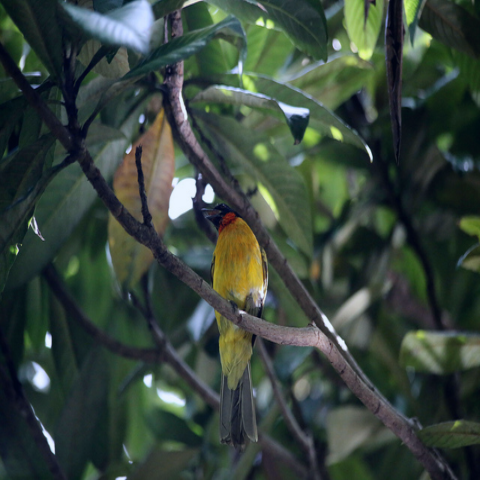

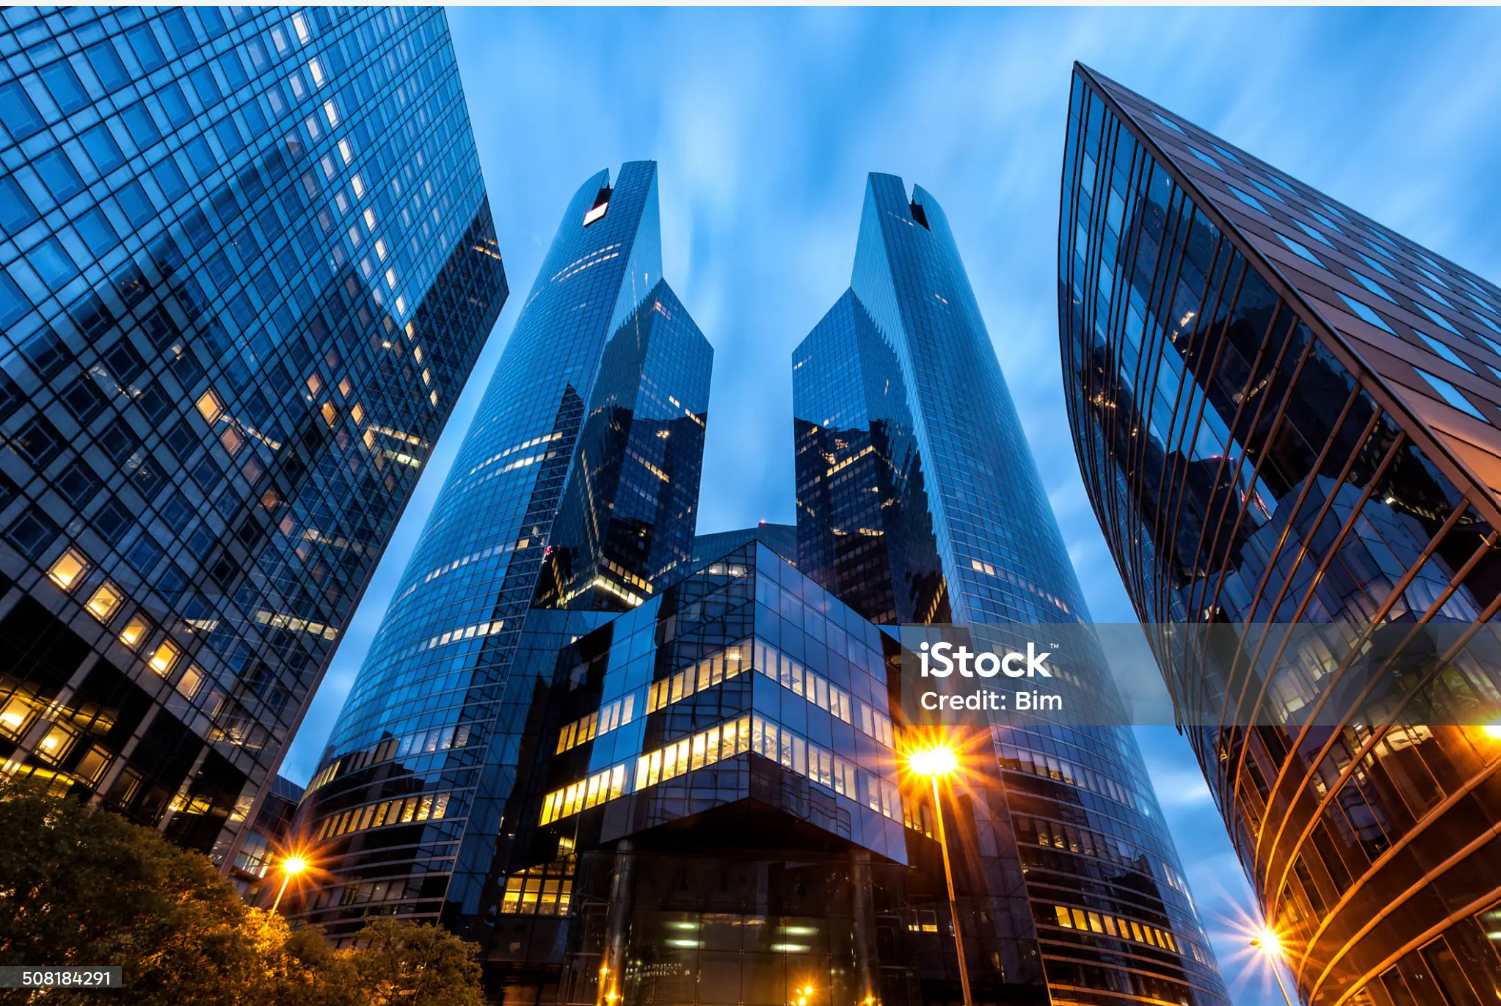

In [65]:
from IPython.display import Image, display
display(Image("img.png"))
display(Image("img2.png"))

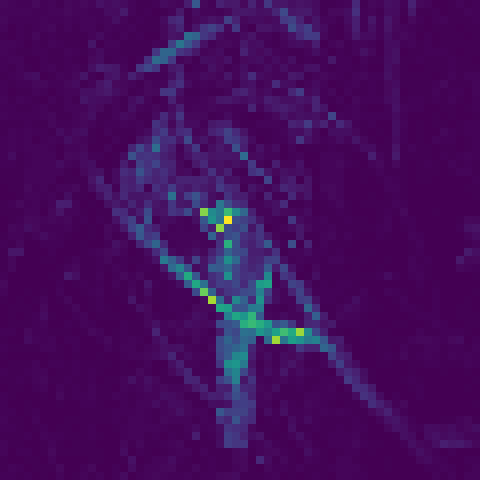

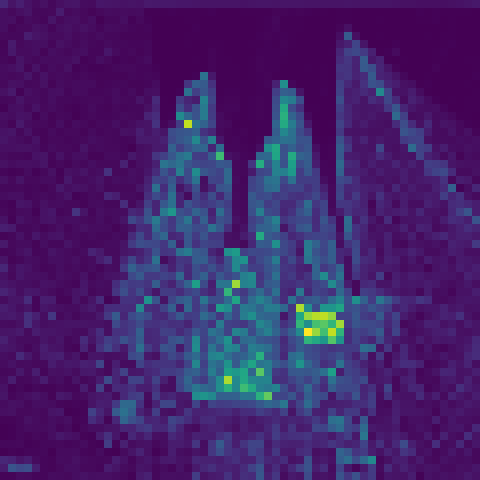

In [66]:
from IPython.display import Image, display
display(Image("output1/attn-head0.png"))
display(Image("output2/attn-head0.png"))

In [69]:
%cd ..

c:\Users\SHARS\OneDrive\문서\GitHub\assignment-5-HarshvardhanSingh841


C:\Users\SHARS\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [71]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_size = embed_size
        self.head_dim = embed_size // num_heads

        assert self.head_dim * num_heads == embed_size, "Embedding size must be divisible by number of heads."

        self.query_linear = nn.Linear(embed_size, embed_size)
        self.key_linear = nn.Linear(embed_size, embed_size)
        self.value_linear = nn.Linear(embed_size, embed_size)
        self.fc_out = nn.Linear(embed_size, embed_size)

        # Add a variable to store the attention weights
        self.attn_weights = None  # This will hold the attention weights during the forward pass

    def forward(self, query, key, value):
        N = query.size(0)

        # Split the embedding into self.num_heads different heads
        query = query.view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)
        key = key.view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)
        value = value.view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention for each head
        attention, attention_weights = ScaledDotProductAttention()(query, key, value)

        # Store the attention weights
        self.attn_weights = attention_weights  # Save attention weights for later access

        # Concatenate all heads and pass through final linear layer
        attention = attention.transpose(1, 2).contiguous().view(N, -1, self.num_heads * self.head_dim)
        out = self.fc_out(attention)
        return out, attention_weights

C:\Users\SHARS\AppData\Local\Temp\ipykernel_24364\804127030.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_vit_deep.pth'))  # Lo

Files already downloaded and verified


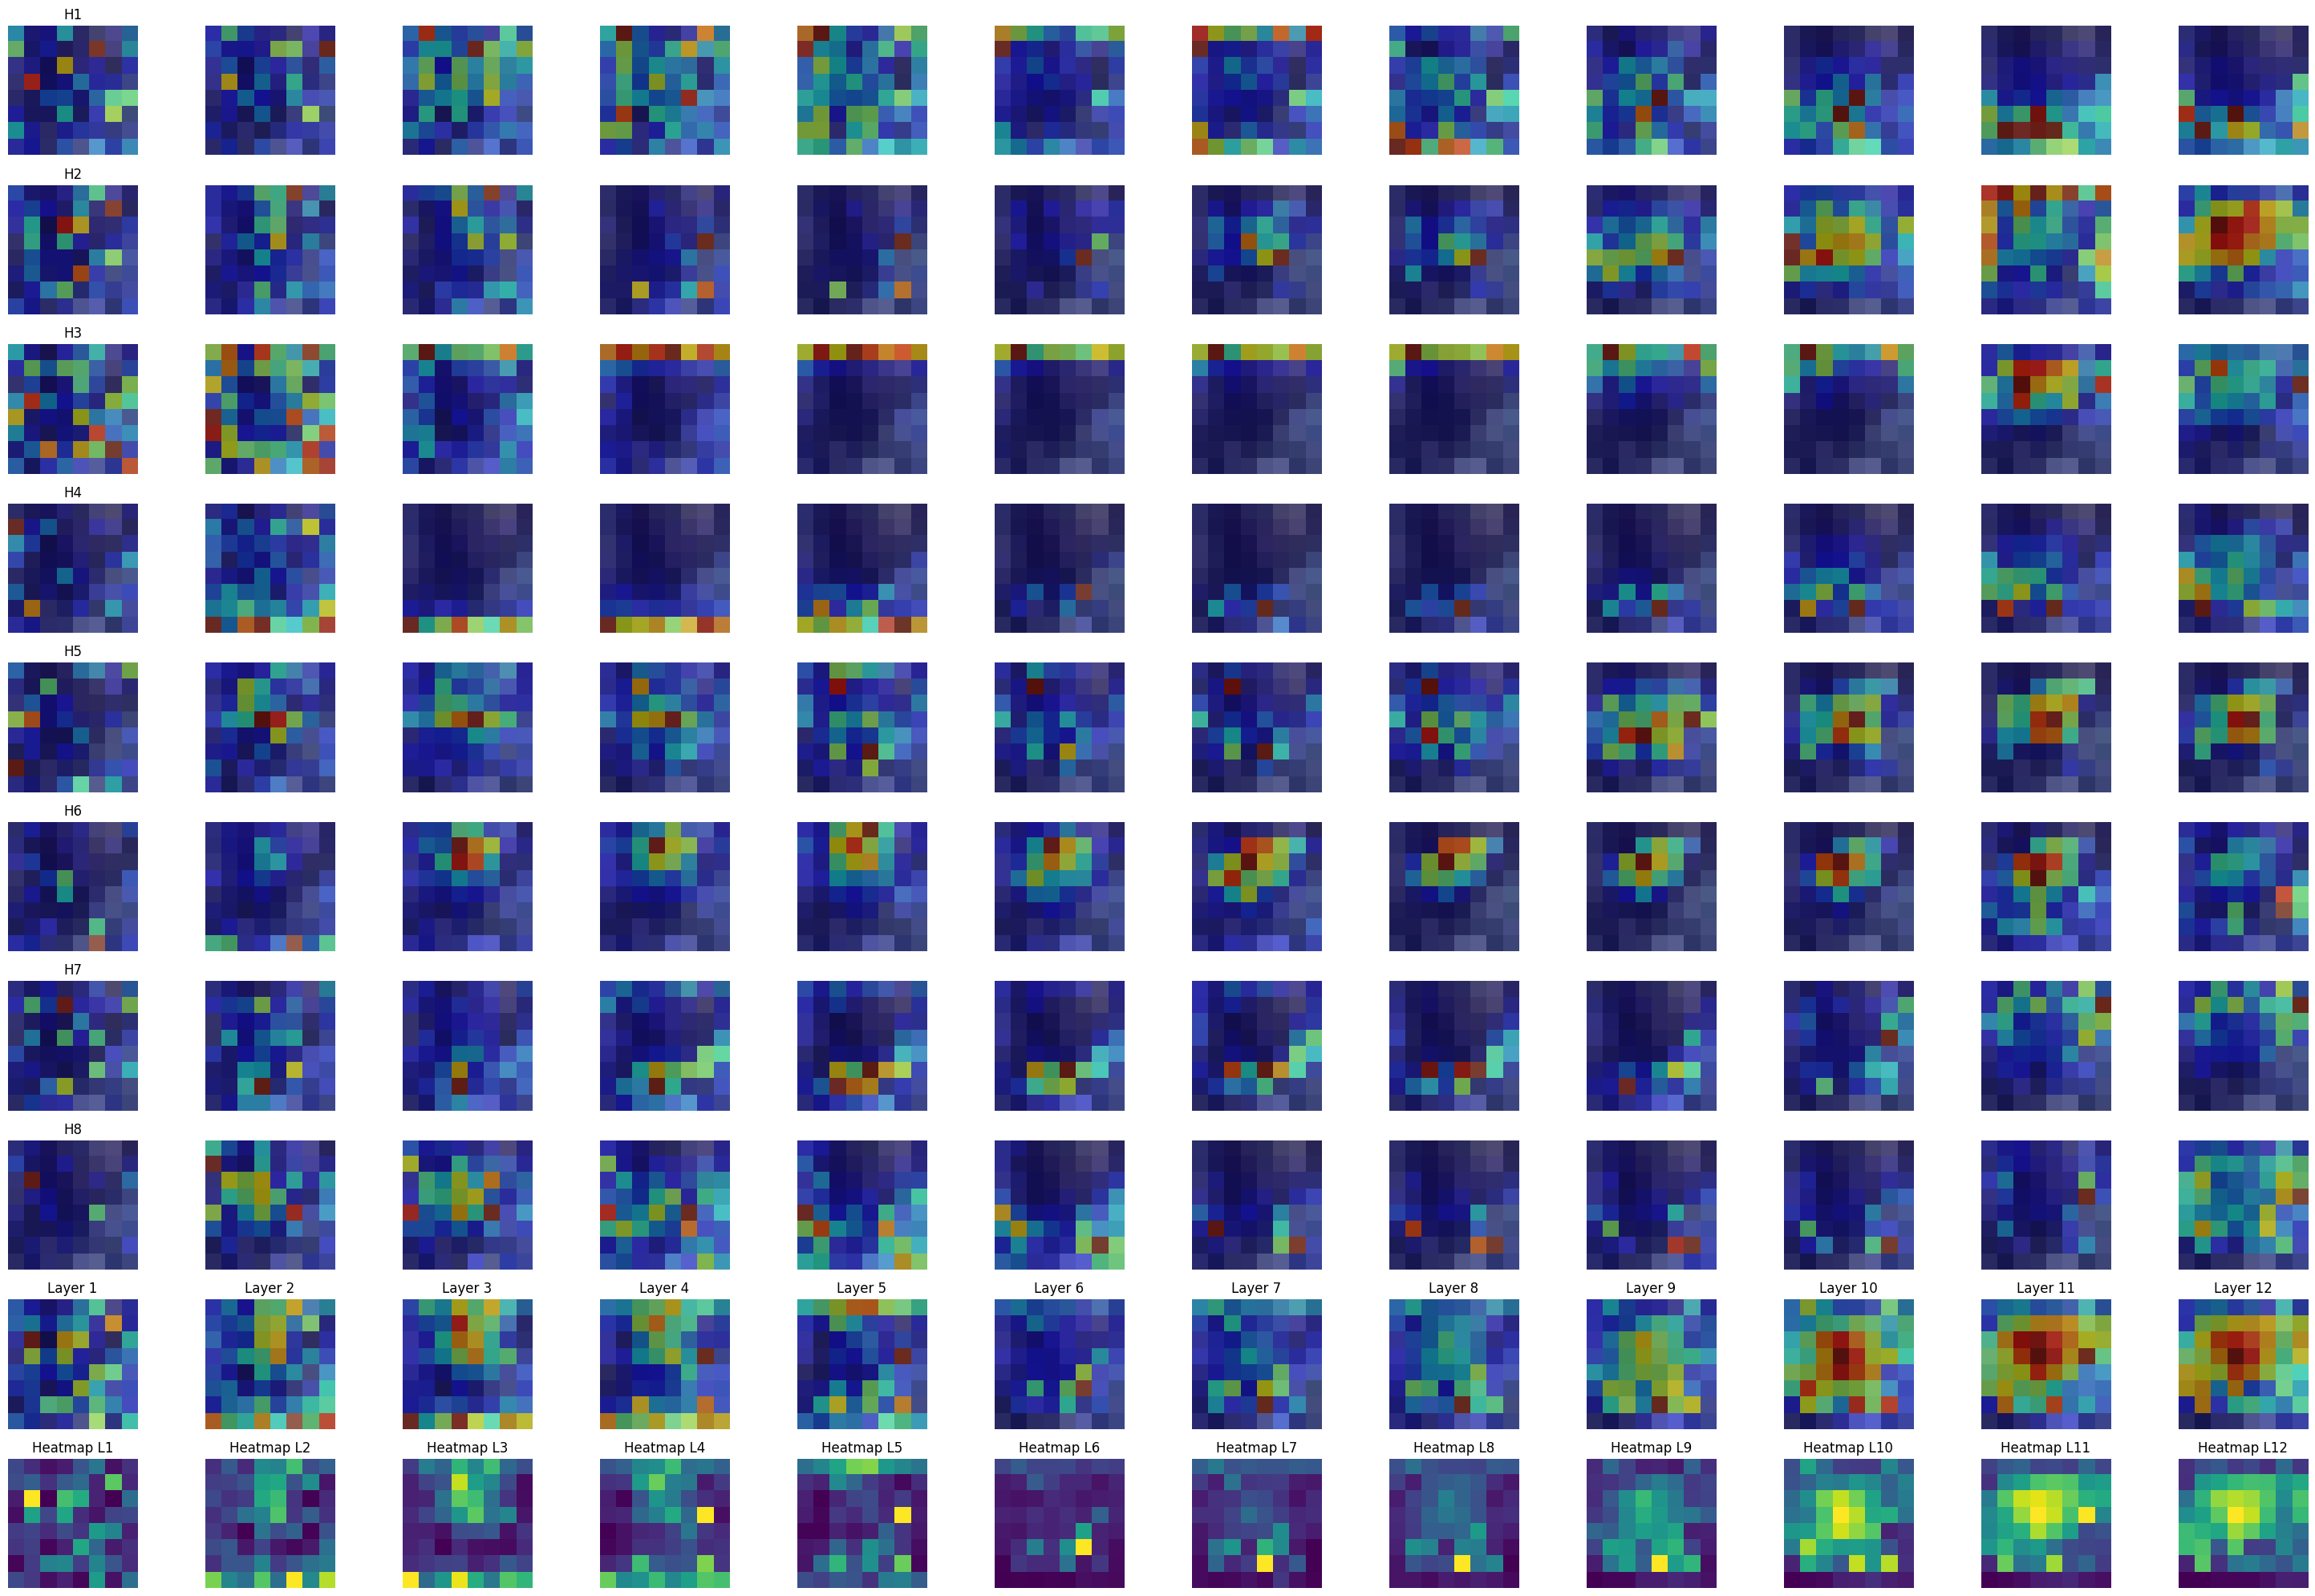

In [72]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import datasets, transforms

# 1. Hook function to capture the attention maps
def get_cls_attentions(model, x):
    attn_maps = []

    def hook_fn(module, input, output):
        attn = module.attn_weights  # (B, heads, N, N)
        cls_attn = attn[:, :, 0, 1:]  # [CLS] to all patches
        attn_maps.append(cls_attn.detach().cpu())  # (B, heads, num_patches)

    handles = []
    for block in model.encoder_layers:  # Access the encoder layers
        handle = block.multihead_attention.register_forward_hook(hook_fn)  # Attach the hook to each layer
        handles.append(handle)

    with torch.no_grad():
        model(x)  # Run the model with the input image

    for handle in handles:  # Remove the hooks after use
        handle.remove()

    return attn_maps  # List of tensors, one per layer

# 2. Function to visualize attention maps
def show_attention_maps(image, attn_maps, patch_size=4):
    # Convert image to numpy for display
    img = image.permute(1, 2, 0).numpy()

    num_layers = len(attn_maps)
    num_heads = attn_maps[0].shape[1]
    num_patches = attn_maps[0].shape[2]
    grid_size = int(np.sqrt(num_patches))

    fig, axes = plt.subplots(num_heads + 2, num_layers, figsize=(num_layers * 2.5, (num_heads + 2) * 2))

    for layer_idx in range(num_layers):
        cls_attn = attn_maps[layer_idx][0]  # (heads, num_patches)

        for head_idx in range(num_heads):
            ax = axes[head_idx, layer_idx]
            attn = cls_attn[head_idx].reshape(grid_size, grid_size)
            ax.imshow(img)
            ax.imshow(attn, cmap='jet', alpha=0.5)
            ax.axis('off')
            if layer_idx == 0:
                ax.set_title(f'H{head_idx + 1}')

        # Average over heads
        avg_attn = cls_attn.mean(dim=0).reshape(grid_size, grid_size)
        ax = axes[num_heads, layer_idx]
        ax.imshow(img)
        ax.imshow(avg_attn, cmap='jet', alpha=0.5)
        ax.set_title(f'Layer {layer_idx + 1}')
        ax.axis('off')

        # Raw attention map
        ax = axes[num_heads + 1, layer_idx]
        ax.imshow(avg_attn, cmap='viridis')
        ax.set_title(f'Heatmap L{layer_idx + 1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# 3. Load your model and test data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer(
    num_classes=10,
    embed_size=256,       # token embedding dimension
    num_heads=8,          # attention heads (reduced for stability/generalization)
    num_layers=12,         # slightly deeper transformer
    patch_size=4,
    feedforward_dim=1024  # hidden dim in each MLP block
)  # Assuming 10 classes for CIFAR-10
model.load_state_dict(torch.load('best_vit_deep.pth'))  # Load your best model
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# 4. Load a sample from CIFAR-10
transform = transforms.Compose([transforms.ToTensor()])
cifar10_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(cifar10_testset, batch_size=1, shuffle=True)

# Get one test sample
test_iter = iter(test_loader)
img, label = next(test_iter)
img = img.to(device)  # Move image to the same device as model

# 5. Get attention maps from the model
attn_maps = get_cls_attentions(model, img)

# 6. Visualize the attention maps
show_attention_maps(img[0].cpu(), attn_maps)  # Show attention maps for the first image

Attention rollout

C:\Users\SHARS\AppData\Local\Temp\ipykernel_24364\421771751.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_vit_deep.pth"))  # Un

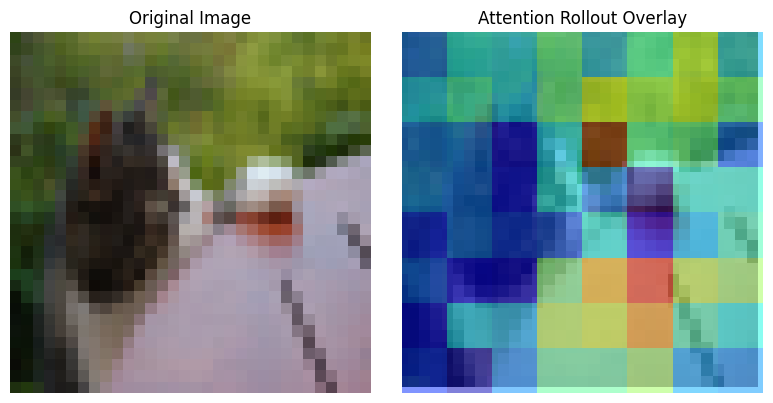

In [74]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Hook function to extract attention weights
def compute_attention_rollout(model, x):
    attn_matrices = []

    def hook_fn(module, input, output):
        # Extract attention weights (averaged over all heads)
        attn = output[1].detach().cpu()  # Shape: (B, heads, N, N)
        avg_attn = attn.mean(dim=1)  # Average across heads: (B, N, N)
        attn_matrices.append(avg_attn)

    handles = []
    for block in model.encoder_layers:
        handle = block.multihead_attention.register_forward_hook(hook_fn)
        handles.append(handle)

    with torch.no_grad():
        model(x)

    for handle in handles:
        handle.remove()

    # Start rollout: Identity matrix + attention
    rollout = torch.eye(attn_matrices[0].size(-1))  # Identity matrix for initial state
    for attn in attn_matrices:
        attn = attn[0]  # Take first image (batch size = 1)
        attn = attn + torch.eye(attn.size(0))  # Add residual connection (identity)
        attn = attn / attn.sum(dim=-1, keepdim=True)  # Normalize attention weights
        rollout = attn @ rollout  # Matrix multiplication (rollout)

    return rollout  # Shape: (num_tokens, num_tokens)

# Function to visualize attention rollout overlaid on the image
def show_attention_rollout_with_image(img_tensor, rollout, patch_size=4):
    img = img_tensor.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)  # Normalize image

    # Attention from [CLS] token to all patch tokens (skip [CLS] itself)
    cls_attn = rollout[0, 1:].numpy()  # Exclude [CLS] itself
    num_patches = cls_attn.shape[0]
    grid_size = int(np.sqrt(num_patches))

    attn_map = cls_attn.reshape(grid_size, grid_size)
    attn_map = attn_map / attn_map.max()  # Normalize for visualization

    # Create the plot
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    # Plot original image
    axs[0].imshow(img)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    # Plot image with attention rollout overlay
    axs[1].imshow(img)
    axs[1].imshow(attn_map, cmap='jet', alpha=0.5, extent=(0, 32, 32, 0))
    axs[1].set_title("Attention Rollout Overlay")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

# Loading the model and CIFAR-10 data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer(
    num_classes=10,
    embed_size=256,       # token embedding dimension
    num_heads=8,          # attention heads (reduced for stability/generalization)
    num_layers=12,         # slightly deeper transformer
    patch_size=4,
    feedforward_dim=1024  # hidden dim in each MLP block
).to(device)  # Assuming 10 classes for CIFAR-10
model.load_state_dict(torch.load("best_vit_deep.pth"))  # Uncomment to load pretrained model
model.eval()

# Get one test image from CIFAR-10
test_iter = iter(test_loader)
img, label = next(test_iter)
img = img[:1].to(device)  # Get just one image

# Compute the attention rollout
rollout = compute_attention_rollout(model, img)

# Visualize the original image and attention rollout overlay
show_attention_rollout_with_image(img[0].cpu(), rollout)

visualising positional embeddings

C:\Users\SHARS\AppData\Local\Temp\ipykernel_24364\1575258035.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_vit_1d_learned.pth")

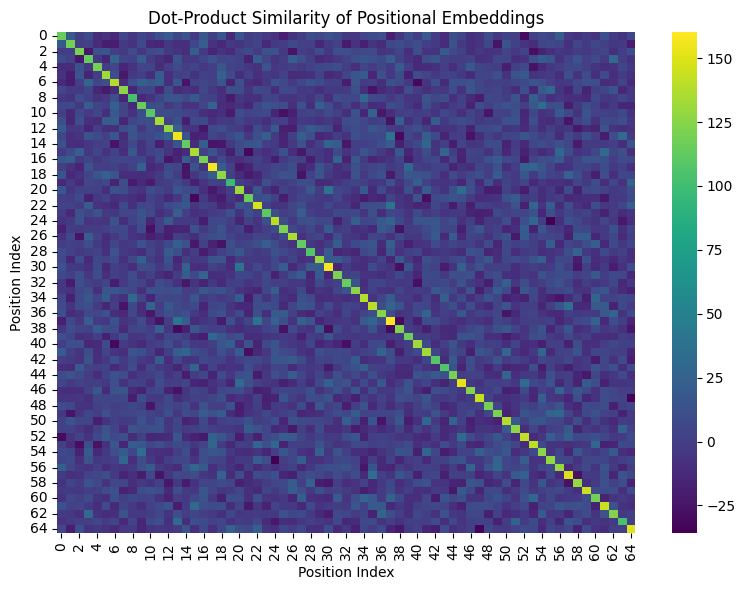

In [76]:
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import torch.nn.functional as F

def visualize_positional_embedding_similarity(model):
    # Extract the learned positional embedding from the model
    pos_embed = model.pos_embed.squeeze(0)  # (1, num_tokens, emb_dim) -> (num_tokens, emb_dim)
    
    # Compute dot-product similarity between positional embeddings
    similarity = pos_embed @ pos_embed.T  # (num_tokens, num_tokens)

    # Optional: normalize for cosine similarity instead of dot-product
    # similarity = F.cosine_similarity(pos_embed.unsqueeze(1), pos_embed.unsqueeze(0), dim=-1)

    # Plot the similarity matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity.cpu().detach().numpy(), cmap='viridis')
    plt.title("Dot-Product Similarity of Positional Embeddings")
    plt.xlabel("Position Index")
    plt.ylabel("Position Index")
    plt.tight_layout()
    plt.show()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained model
model = VisionTransformer(
    num_classes=10,
    embed_size=128,
    num_heads=4,
    num_layers=6,
    patch_size=4,
    feedforward_dim=512,
    positional_embedding_type="1d_learned"  # Use the same type as during training
).to(device)
model.load_state_dict(torch.load("best_vit_1d_learned.pth"))
model.eval()

# Visualize the positional embedding similarity
visualize_positional_embedding_similarity(model)

Okay with this we are finished with question1 